# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import sys
import os
import time
from datetime import datetime
from importlib import reload
from pprint import pprint
from pathlib import Path
from tqdm.notebook import tqdm

# sklearn imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from scipy.stats import t

# tensorflow and keras imports
import tensorflow.keras.initializers
from tensorflow.keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# to make this notebook's output stable across runs
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# surpress scientific notation
pd.options.display.float_format = '{:.8f}'.format

# custom library with functions
py_file_location = '../'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path

from customdslib import model_analysis as ma
from customdslib import preprocessing as pre
from customdslib import plotting

py_file_location = '../customdslib/'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path


In [2]:
# imports for plotting
from matplotlib import rcParams
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
matplotlib_axes_logger.setLevel('ERROR')


# global custom setting for the running commands matplotlib or sns
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['scatter.marker'] = 'o'

sns.set_style('whitegrid', {'axes.facecolor': '.995'})

# use the custom style sheet 
plt.style.use('nk_ML_DS.mplstyle')  

# Computing environment
<a id="Versions" > 

In [3]:
%reload_ext watermark
%watermark -a "Author: Nicole Königstein" 
%watermark -d -v -m 
%watermark -v -p numpy,matplotlib,pandas,seaborn

Author: Nicole Königstein
2021-08-18 

CPython 3.7.3
IPython 7.19.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 20.2.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
CPython 3.7.3
IPython 7.19.0

numpy 1.19.5
matplotlib 3.4.2
pandas 1.2.3
seaborn 0.11.1


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpu_devices, 'GPU')
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print('Using GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('Using CPU')

Using CPU


# Notebook running settings

### Model training

In [4]:
do_training = True 

### Cross validation

<font color=red><b>WARNING:</b> Changing this to `True` will take many hours to run.</font>

In [5]:
cross_val = False 

# if the search will be performed in parallel or not, -1 means parallel choose one to not running parallel
n_jobs = -1

#### Use cross validation data

In [6]:
# which paramters of the cross validation to use for training the model
run_1 = True
run_2 = False

# if cross validation data should be used
use_cv = True

### Training window

In [7]:
n_steps = 5
n_steps_ahead = 5

### Training settings

In [8]:
max_epochs = 5000
batch_size = 1200

es = EarlyStopping(monitor='loss', mode='min', verbose=1,
                   patience=25, min_delta=3e-5, restore_best_weights=True)

### Metrics

In [9]:
metrics = ['mse', 'mae']

### Uni- or Mulitvariate

In [10]:
# set to uni to just train on the price
uni = False

# Load data

### Datapath

In [11]:
PATH = '../'

### Get data

In [12]:
ticker = 'AMZN'

In [13]:
df1 = pd.read_csv(PATH + 'data/df_cut.csv')
df2 = pd.read_csv(PATH + 'data/df_cut2.csv')

data1 = df1.loc[df1['ticker'] == ticker]
data2 = df2.loc[df2['ticker'] == ticker]

In [14]:
data1.head()

Unnamed: 0 ticker        date  article_count        close           n  \
0           0   AMZN  2015-01-02     2.00000000 308.51998901  2.00000000   
1           1   AMZN  2015-01-05     1.00000000 302.19000244  0.00000000   
2           2   AMZN  2015-01-06    30.00000000 297.35530121  4.00000000   
3           3   AMZN  2015-01-07    19.00000000 298.42001343  5.00000000   
4           4   AMZN  2015-01-08    27.00000000 300.45999146 10.00000000   

            p   sentiment  conv_filter  
0  0.00000000 -1.09861229   0.32360229  
1  1.00000000  0.69314718   0.33997585  
2 26.00000000  1.68639895   0.34594188  
3 14.00000000  0.91629073   0.34450627  
4 17.00000000  0.49247649   0.35915787

In [15]:
if uni:
    data1 = data1[['close', 'date']]
    data2 = data2[['close', 'date']]
else:
    data1 = data1[['close', 'conv_filter', 'date']]
    data2 = data2[['close', 'conv_filter', 'date']]


# convert date object to datetime
format = '%Y-%m-%d'
data1['date'] = pd.to_datetime(data1['date'], format=format)
data1.set_index('date', inplace=True)

data2['date'] = pd.to_datetime(data2['date'], format=format)
data2.set_index('date', inplace=True)


data1.head()

close  conv_filter
date                                
2015-01-02 308.51998901   0.32360229
2015-01-05 302.19000244   0.33997585
2015-01-06 297.35530121   0.34594188
2015-01-07 298.42001343   0.34450627
2015-01-08 300.45999146   0.35915787

# Prepare dataset

### Split the dataset

In [16]:
mu, sigma, data_train, data_val, data_test =  pre.prepare_data_val(data1, data2, weight=0.6, log_=True)

### Get lagged features

In [17]:
x_train, y_train = pre.get_lagged_dataset(data_train, n_steps, n_steps_ahead)
x_val, y_val = pre.get_lagged_dataset(data_val, n_steps, n_steps_ahead)
x_test, y_test = pre.get_lagged_dataset(data_test, n_steps, n_steps_ahead)

# Display the shapes
print([tensor.shape for tensor in (x_train, y_train, x_val, y_val, x_test, y_test)])

[(1249, 5, 2), (1249, 5, 1), (157, 5, 2), (157, 5, 1), (102, 5, 2), (102, 5, 1)]


# Model function

In [18]:
init = tf.keras.initializers.glorot_uniform(seed)
recurr_init = tf.keras.initializers.orthogonal(seed)
input_shape = (x_train.shape[1], x_train.shape[-1])  # input lags, features

n_units = 10
l1_reg = 0


def SimpleRNN_(n_units=n_units, l1_reg=l1_reg, dropout_rate=0.5, metrics = ['mse']):
    model = Sequential()
    model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=init,
                        bias_initializer=init, recurrent_initializer=recurr_init,
                        kernel_regularizer=l1(l1_reg), input_shape=input_shape,
                        unroll=True, stateful=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_steps_ahead, kernel_initializer=init, bias_initializer=init,
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=metrics)
    return model


In [19]:
params = {
    'rnn': {
        'model': None, 'network': SimpleRNN_, 'l1_reg': 0, 'n_units': 10,
        'dropout_rate': 0.3, 'color': '#d3d1d1', 'label': 'RNN'},
}

# Load pre-trained model


Training the models takes several hours. To save time, you may load the already fitted models instead.

In [20]:
folder = '{}/'.format(ticker)
model_name = 'RNNs-{}-{}{}-conv-SAVED-'.format(ticker, n_steps, n_steps_ahead)
lags = str(n_steps)
                                
if not do_training:
    for key in params.keys():
        print('Loading model weights of {}'.format(key))
        params[key]['model'] = load_model(
            '../trained-RNNs/'+ folder + model_name + key + lags + '.hdf5')

# Cross-validation

In [21]:
# we need to reshape the data to fit the model
y_train = y_train.reshape(-1, n_steps_ahead)

In [22]:
if do_training and cross_val:
    n_units = [60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
    l1_reg = [1e-4, 1e-3, 0.01, 0.1, 0]
    dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7]
    # units: 7; reg: 6, dropout: 5 => 210 CV trainings

    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search

    param_grid = {'n_units': n_units,
                  'l1_reg': l1_reg,
                  'dropout_rate': dropout_rate}

    # In the kth split, TimeSeriesSplit returns first k folds
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits=5)

    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        networktime = time.time()
        print('Performing cross-validation on model:', key)
        model = KerasRegressor(build_fn=params[key]['network'], epochs=max_epochs,
                               batch_size=batch_size, verbose=0)
        grid = GridSearchCV(estimator=model, param_grid=param_grid,
                            cv=tscv, n_jobs=n_jobs, verbose=3, return_train_score=True)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best score: %f using parameter %s" % 
              (grid_result.best_score_, grid_result.best_params_))
        print("Network Runtime: %0.2f Minutes" %
              ((time.time() - networktime)/60))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['n_units'] = grid_result.best_params_['n_units']
        params[key]['l1_reg'] = grid_result.best_params_['l1_reg']
        params[key]['dropout_rate'] = grid_result.best_params_['dropout_rate']

## Save or load the CV results

In [23]:
# which run of the cross validation to use as a basis
if run_1: 
    cv_folder = '{}/run_1/'.format(ticker)
    
elif run_2:
    cv_folder = '{}/run_2/'.format(ticker)

else:
    cv_folder = '{}/'.format(ticker)

print('Using Cross validation from folder: {}'.format(cv_folder))        

Using Cross validation from folder: AMZN/run_1/


In [24]:
for key in params.keys():
    
    cv_path = '../cross_val/'
    
    if uni:
        # save or load the performance metrics from the CV
        file_name = 'cv_results_df-price-{}-{}-n_steps.csv'.format(
            ticker, n_steps)


        if cross_val:
            results_df = pd.DataFrame.from_dict(grid.cv_results_)
            results_df.to_csv('../cross_val/' + cv_folder +
                              key + '_' + file_name, index=None)
        else:
            results_df = pd.read_csv(
                '../cross_val/' + cv_folder + key + '_' + file_name)
    else:
        # save or load the performance metrics from the CV
        file_name = 'cv_results_df-price-conv-{}-{}-n_steps.csv'.format(
            ticker, n_steps)
        cv_path = '../cross_val/'
        cv_folder = '{}/'.format(ticker)

        if cross_val:
            results_df = pd.DataFrame.from_dict(grid.cv_results_)
            results_df.to_csv('../cross_val/' + cv_folder +
                              key + '_' + file_name, index=None)
        else:
            results_df = pd.read_csv(
                '../cross_val/' + cv_folder + key + '_' + file_name)

In [25]:
if not cross_val and use_cv:
    best_results = results_df.sort_values(by='rank_test_score').iloc[0, :]

    for param_key in params[key]:
        if 'param_' + param_key in best_results:
            params[key][param_key] = best_results['param_' + param_key]

            
params_df = pd.DataFrame.from_dict(params)

params_path = '../params/'
params_folder = '{}/'.format(ticker)

if uni: 
    params_file_name = '_params_df-price-{}-{}-n_steps.csv'.format(ticker, n_steps)

else: 
    params_file_name = '_params_df-price_conv-{}-{}-n_steps.csv'.format(ticker, n_steps)

# save the params    
print('saving params...')
params_df.to_csv(params_path + params_folder + key + params_file_name)            
            
print('Using params: \n')            
pprint(params)           

saving params...
Using params: 

{'rnn': {'color': '#d3d1d1',
         'dropout_rate': 0.6,
         'l1_reg': 0.0,
         'label': 'RNN',
         'model': None,
         'n_units': 150,
         'network': <function SimpleRNN_ at 0x7fddb16b77b8>}}


# Train model with selected parameters

In [26]:
lags = str(n_steps)

!rm -rf ../logs/fit/

if uni: 
    log_dir = '../logs/fit/'+ ticker +'_' + lags + '_uni_'+ key
    
else:
    log_dir = '../logs/fit/'+ ticker +'_' + lags + '_multi_'+ key
tf_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
y_val = y_val.reshape(-1, n_steps_ahead)
hist_folder = 'history/{}/'.format(ticker)

if do_training:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['network'](
            params[key]['n_units'], params[key]['l1_reg'], params[key]['dropout_rate'], metrics=metrics)

        history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_val, y_val), verbose=False,
                            batch_size=batch_size, callbacks=[es, tf_board], shuffle=False)
        params[key]['model'] = model

        if uni:
            history_name = key + \
                '-{}-{}-{}-price-history'.format(ticker,
                                                 n_steps, n_steps_ahead)
        else:
            history_name = key + \
                '-{}-{}-{}-conv-history'.format(ticker, n_steps, n_steps_ahead)

        np.save(PATH + hist_folder + history_name, history.history)
        print('Saved history of', key)

Training rnn model
Restoring model weights from the end of the best epoch: 365.
Epoch 390: early stopping
Saved history of rnn


Saving figure:  rnn_train_val_los_plot_price_conv_AMZN_n_steps_5_n_steps_ahead_5


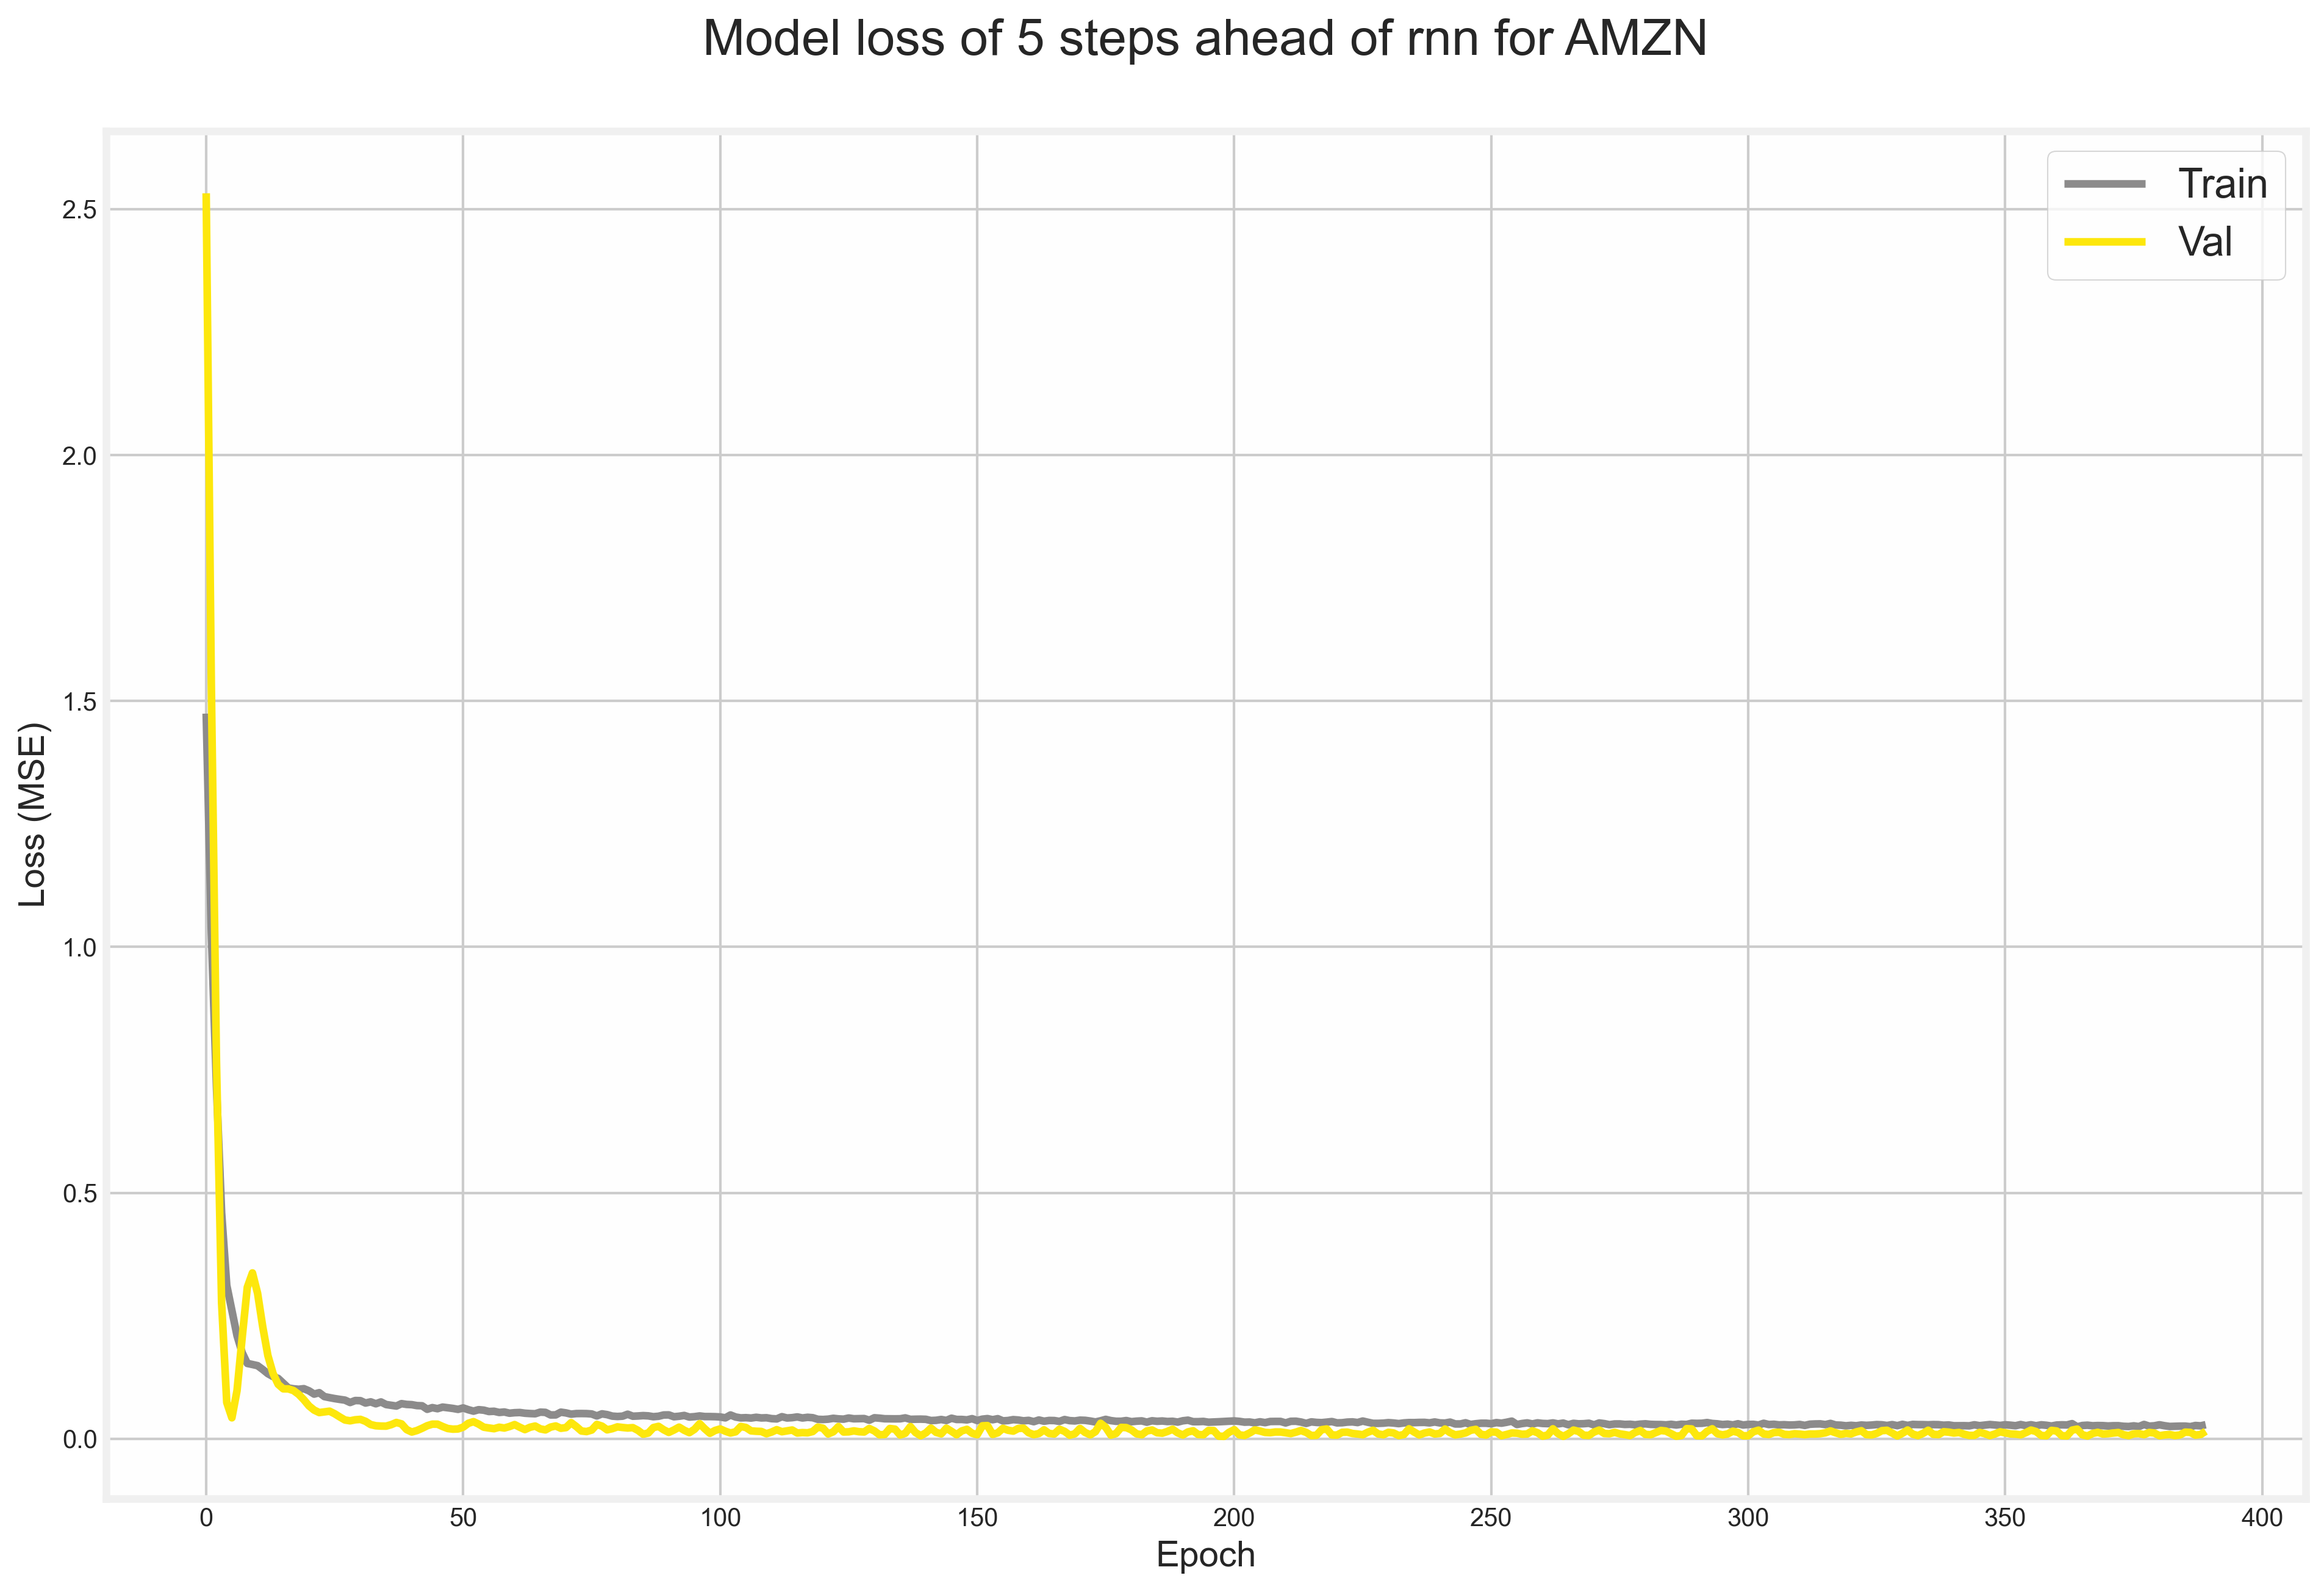

In [28]:
for key in params.keys():
    history = np.load(PATH + hist_folder + history_name +
                      '.npy', allow_pickle='TRUE').item()

    plotting.plot_train_val_loss(
        history, key, ticker, n_steps, n_steps_ahead, uni)

## Save the fitted models

In [29]:
lags = str(n_steps)

if do_training:
    for key in params.keys():
        params[key]['model'].save('../trained-RNNs/' + folder + model_name + key + lags +
                                  '.hdf5', overwrite=True)

## Prediction

In [30]:
y_test = y_test.reshape(-1, n_steps_ahead)

for key in params.keys():
    model = params[key]['model']
    model.summary()

    params[key]['pred_train'] = model.predict(x_train, verbose=True)
    for i in range(n_steps_ahead):
        params[key]['MSE_train steps ahead: ' + str(i+1)] = mean_squared_error(y_train[:, i],
                                                                               params[key]['pred_train'][:, i])
    params[key]['pred_val'] = model.predict(x_val, verbose=True)    

    params[key]['pred_test'] = model.predict(x_test, verbose=True)
    for i in range(n_steps_ahead):
        params[key]['MSE_test steps ahead:' +
                    str(i+1)] = mean_squared_error(y_test[:, i], params[key]['pred_test'][:, i])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 150)               22950     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 5)                 755       
                                                                 
Total params: 23,705
Trainable params: 23,705
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 2ms/step


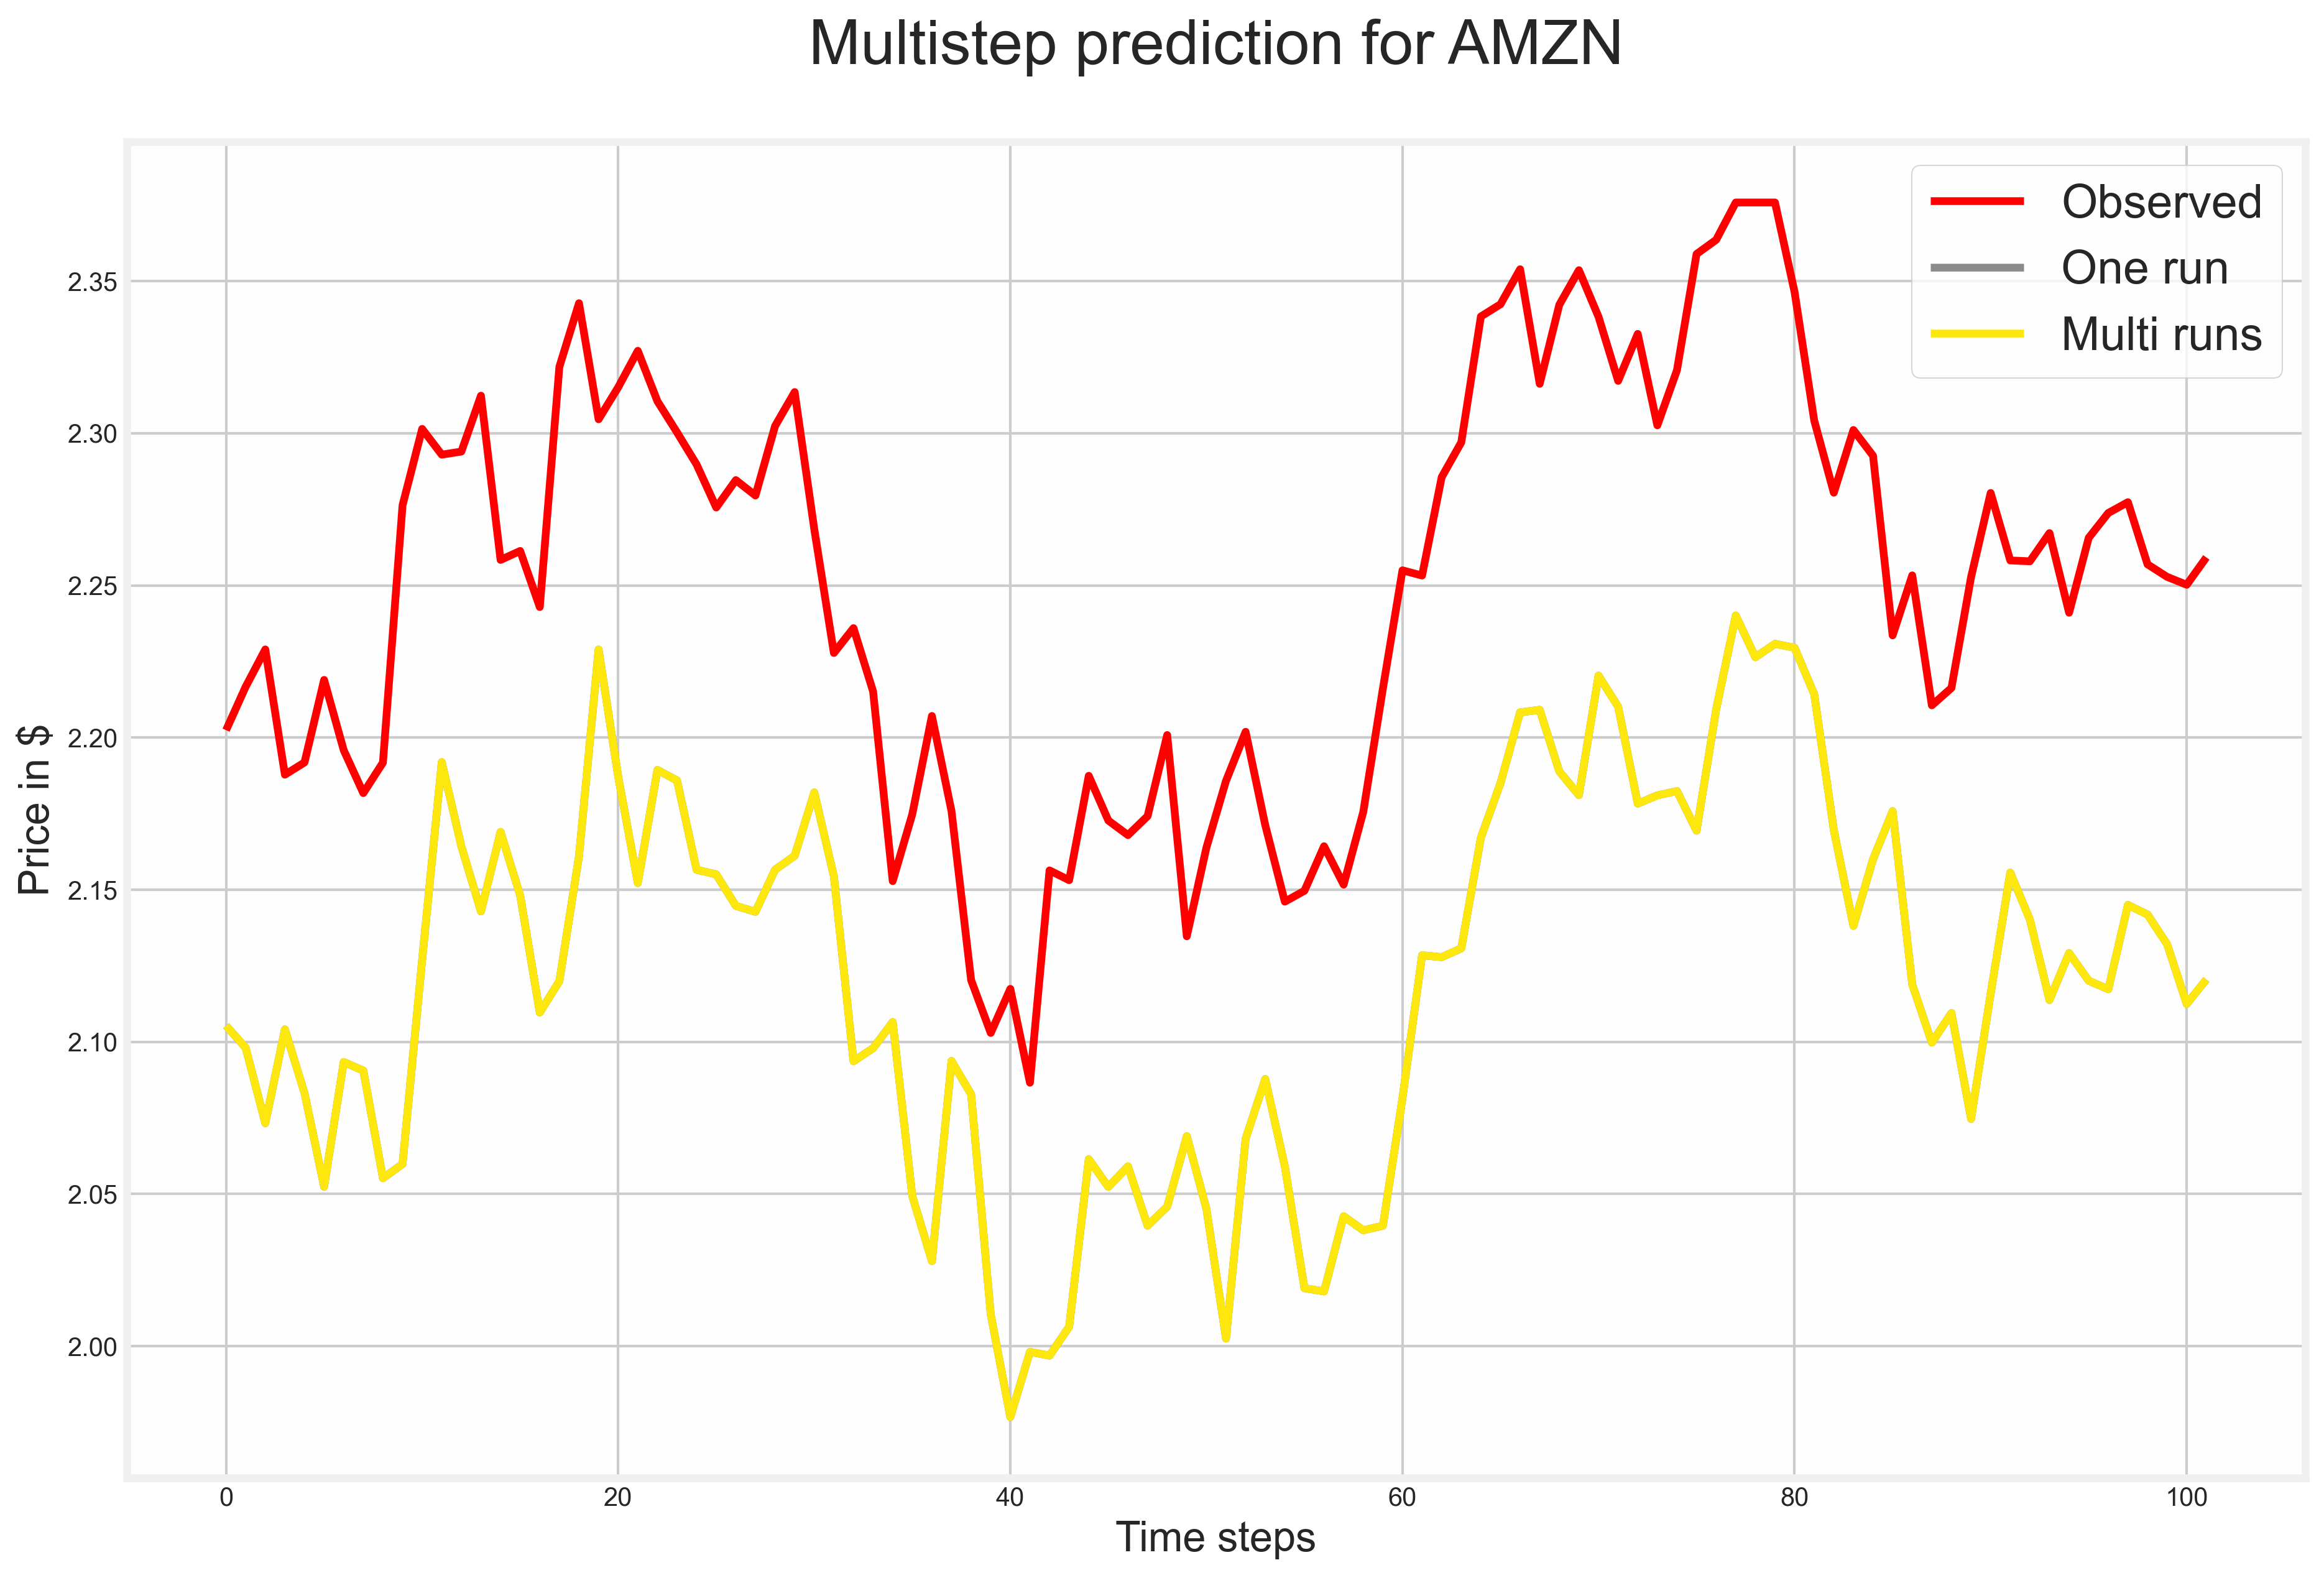

In [31]:
y_pred_clean = np.zeros(y_test.shape)
for i in range(y_test.shape[0]):
    y_pred_clean[i] = model.predict(x_test[i:i+1])
    model.reset_states()
    
plt.rcParams.update({'font.size': 18})
plt.plot(y_test[:,0],'r',label='Observed')
plt.plot(model.predict(x_test)[:,0], label='One run')
plt.plot(y_pred_clean[:,0],label='Multi runs')
plt.ylabel('Price in $', fontsize=16)
plt.xlabel('Time steps', fontsize=16)
plt.title('Multistep prediction for AMZN', fontsize=24)
plt.legend();

In [32]:
# e.g. ['rnn', 'alpharnn'] or ['lstm']
compare = params.keys() 

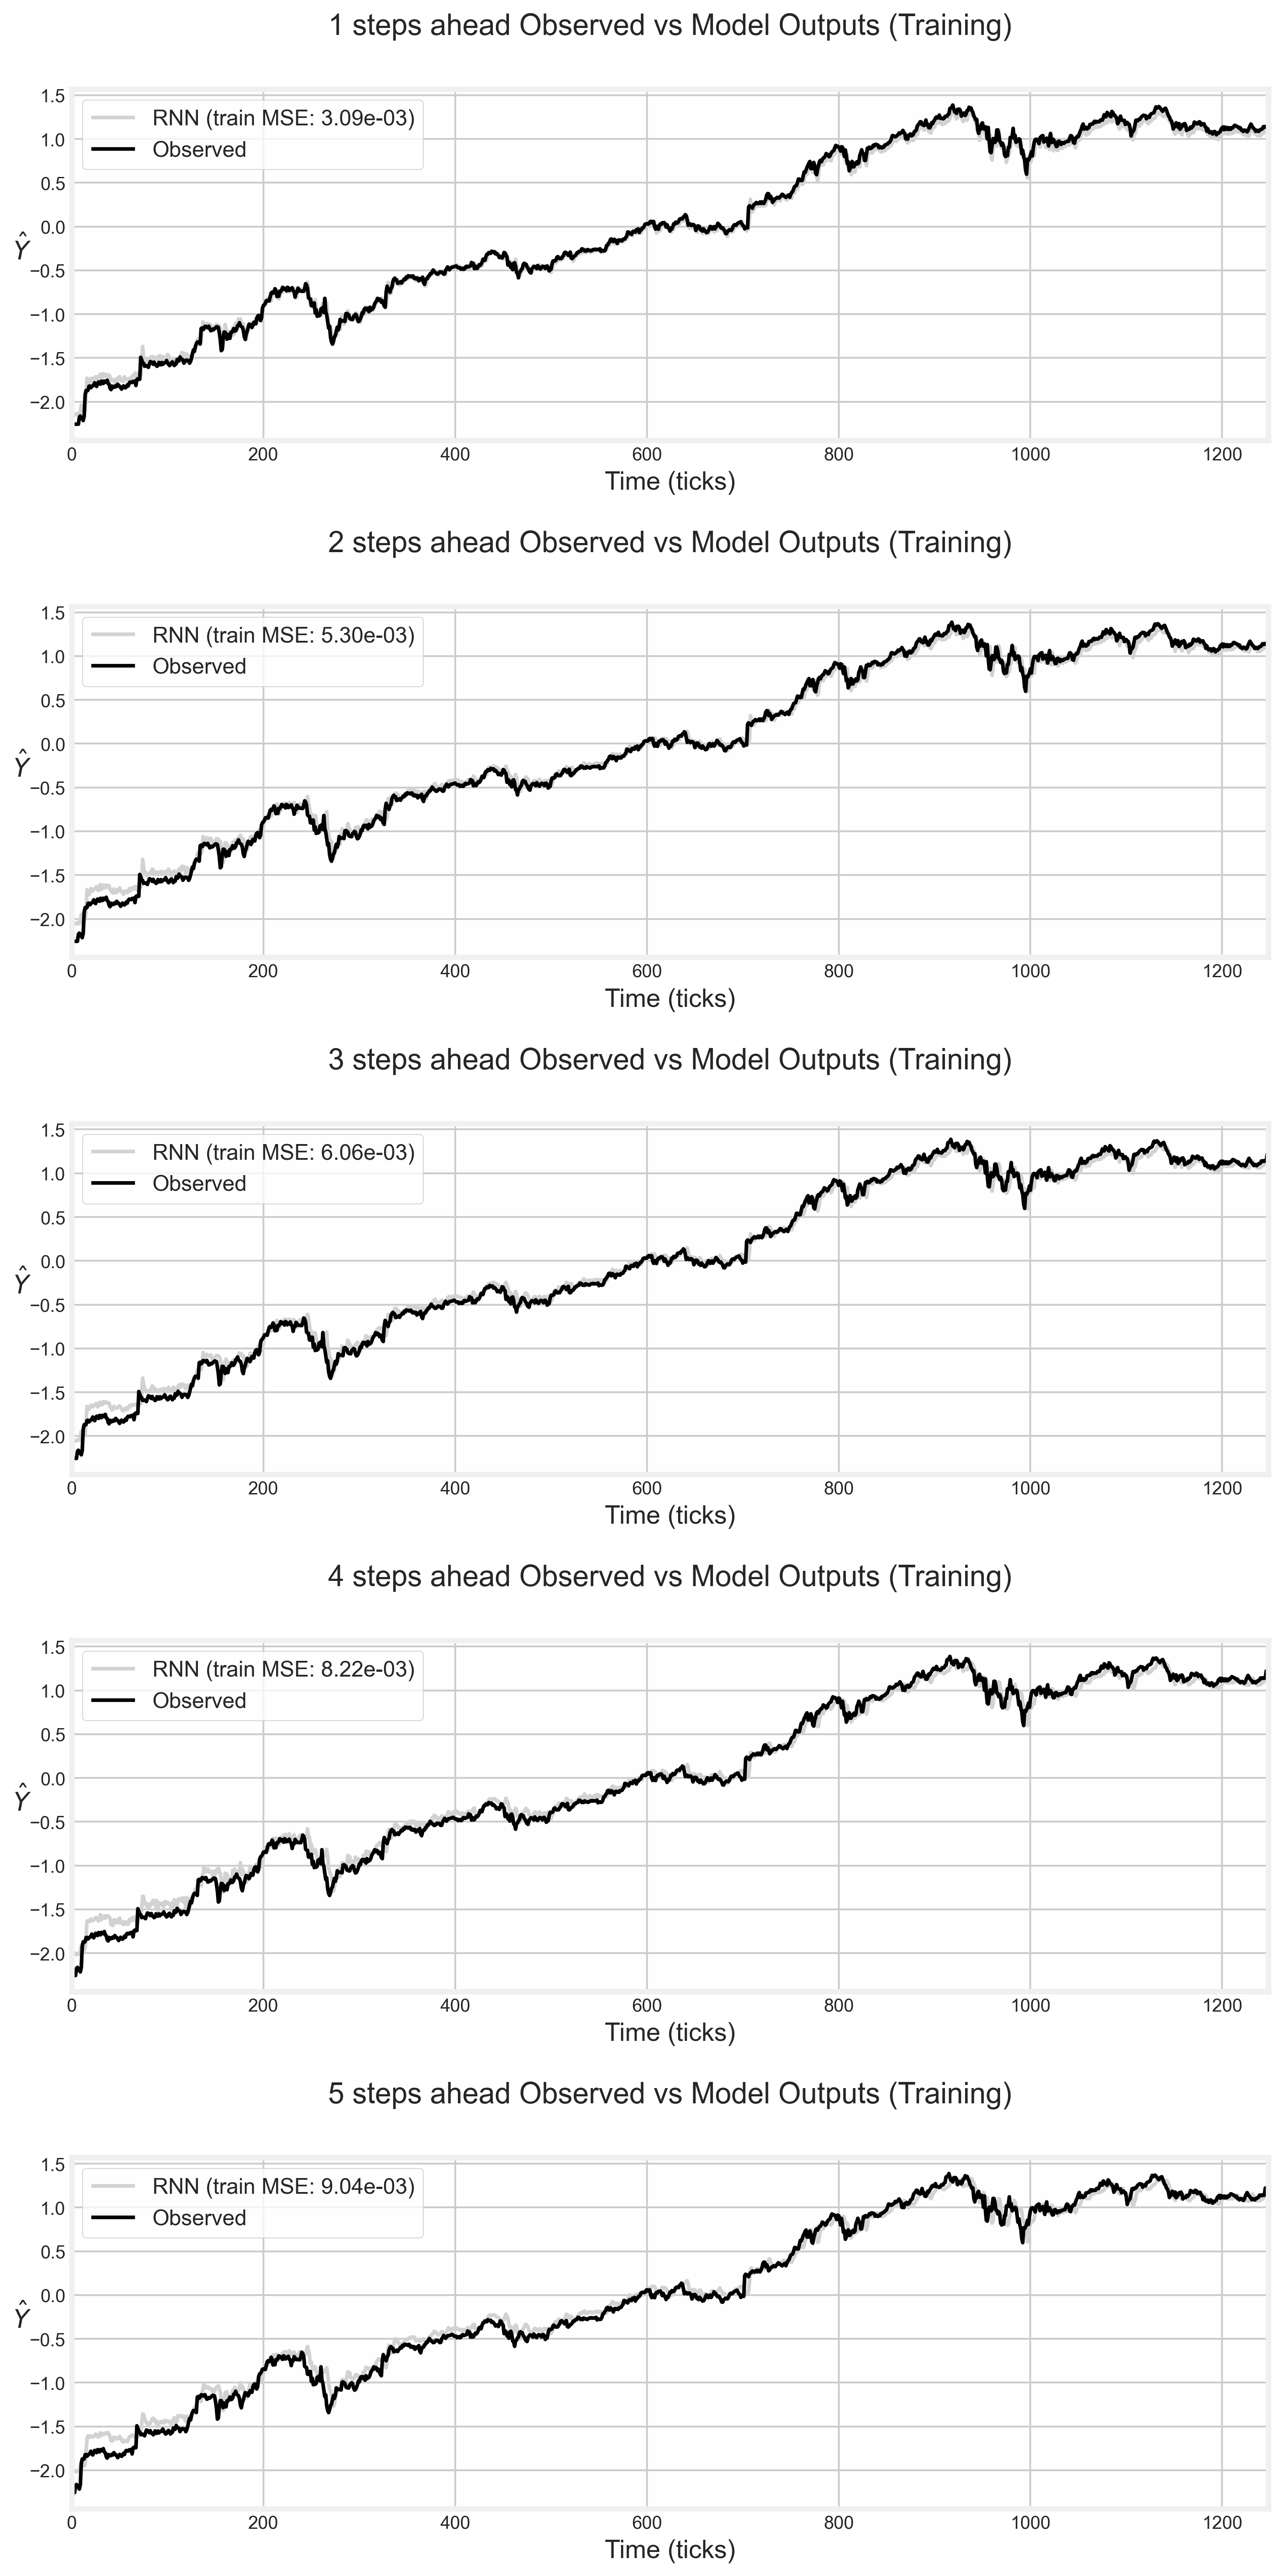

In [33]:
title_train = ' steps ahead Observed vs Model Outputs (Training)'
plotting.prediction_vs_observed_plot(
    compare, params, n_steps_ahead, y_train, y_test, title=title_train, trainplot=True)

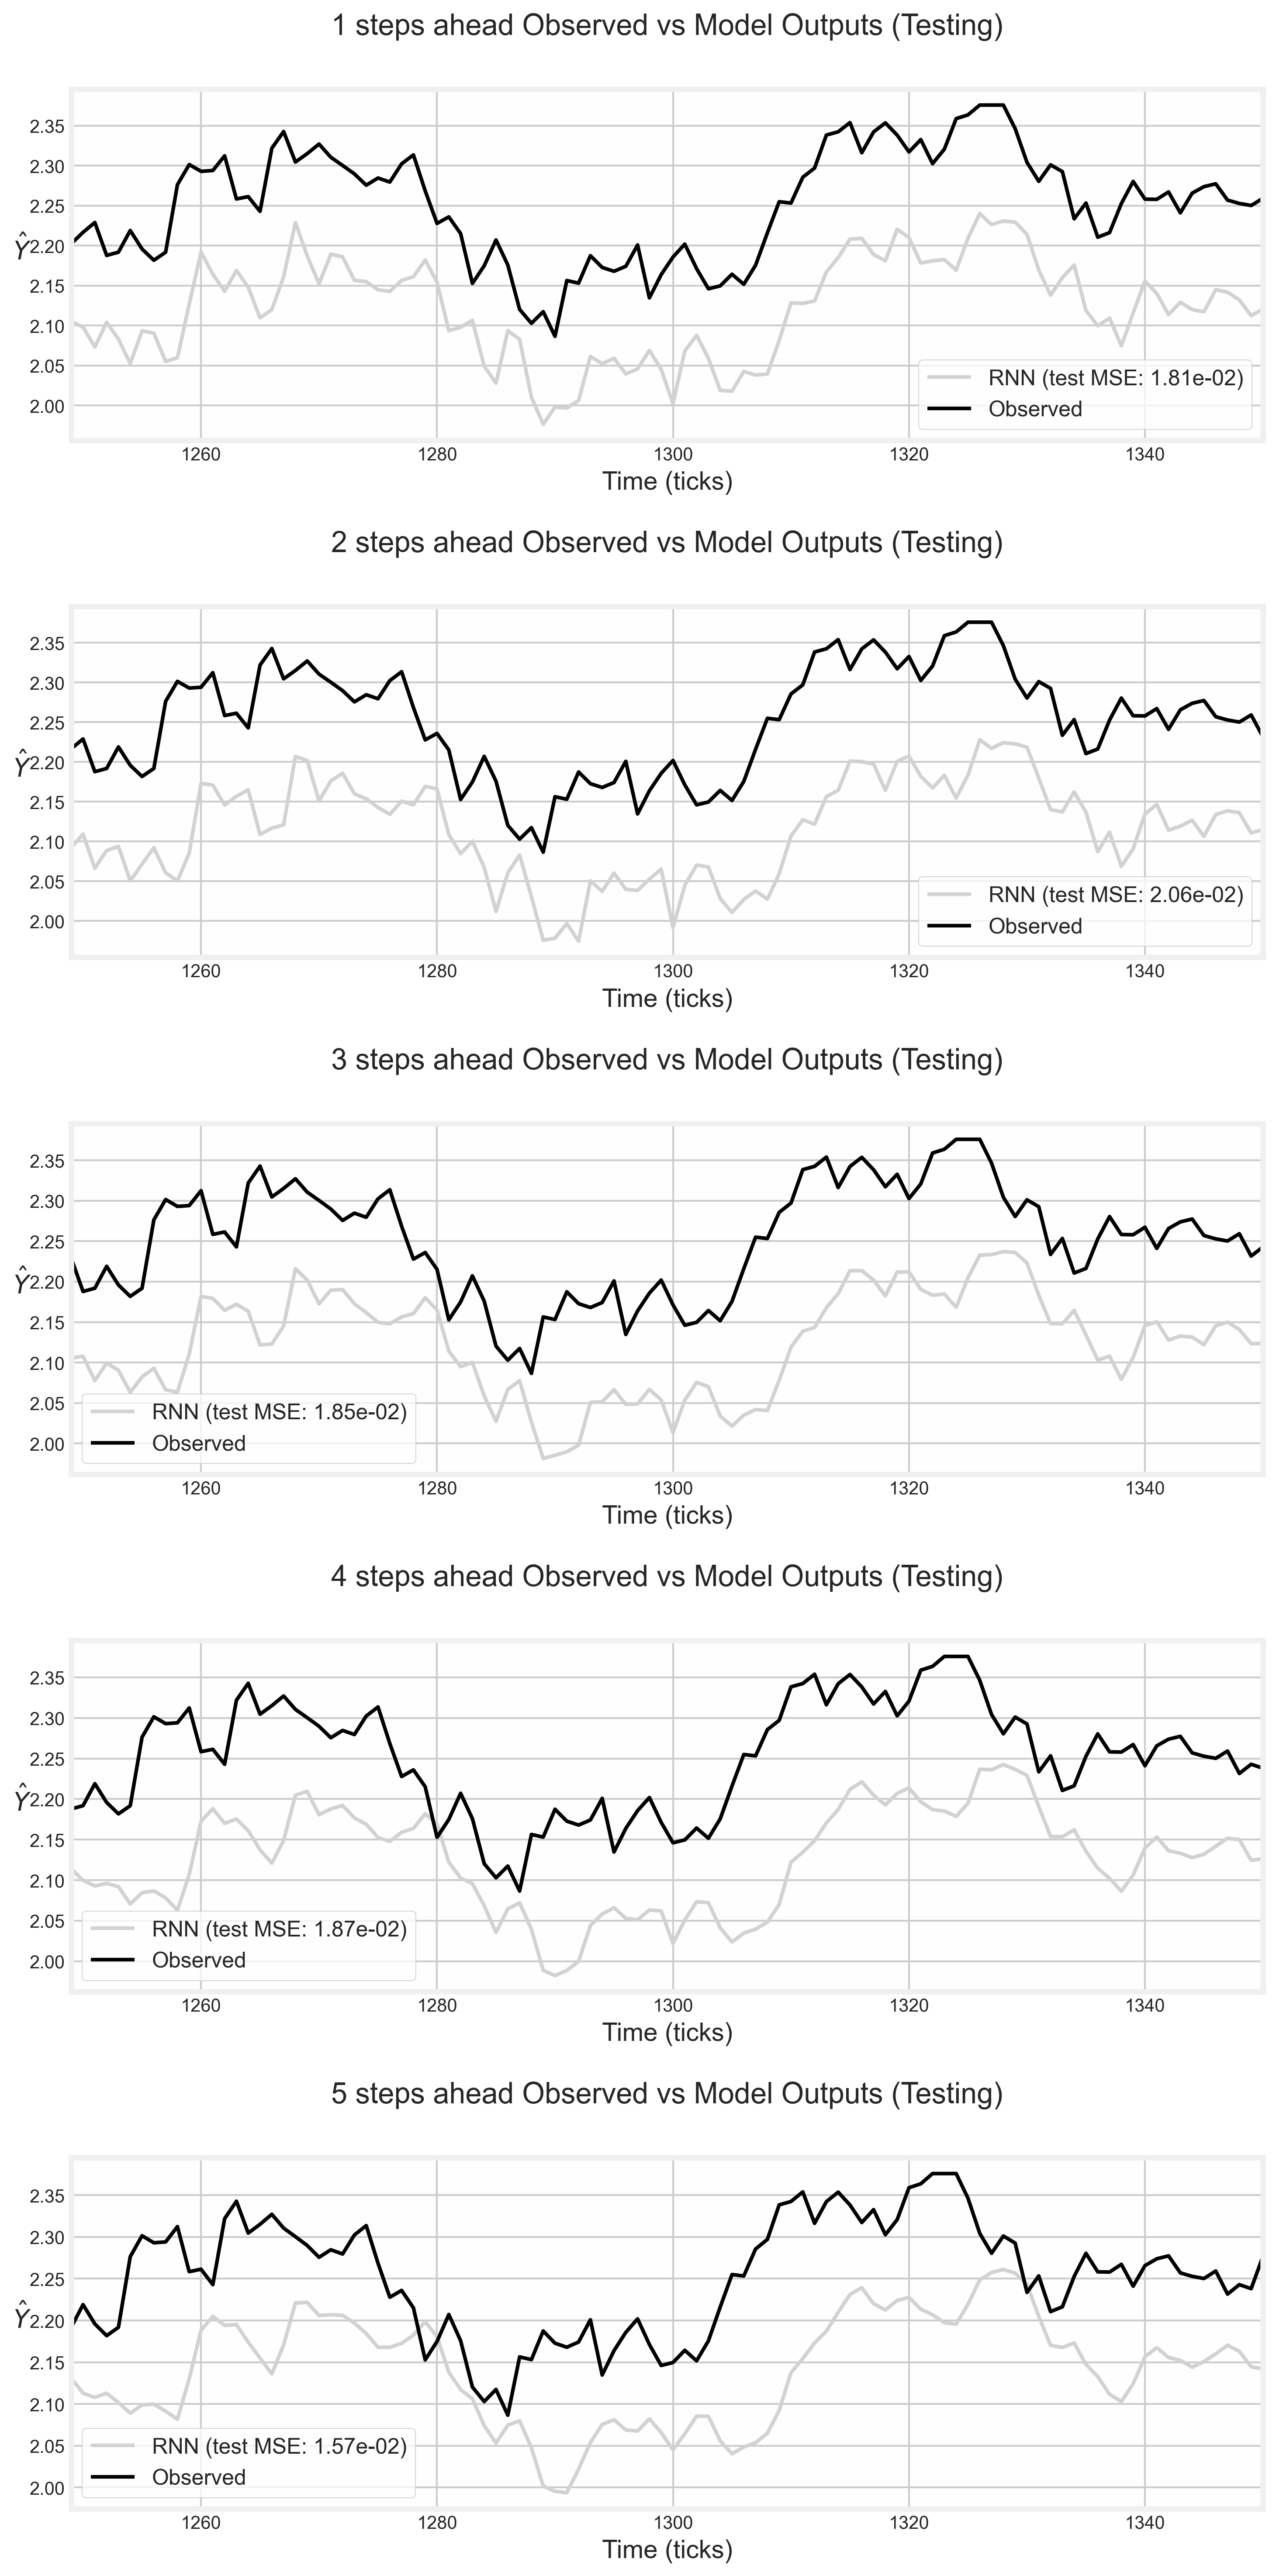

In [34]:
title_test = ' steps ahead Observed vs Model Outputs (Testing)'
plotting.prediction_vs_observed_plot(
    compare, params, n_steps_ahead, y_train, y_test, title=title_test, trainplot=False)

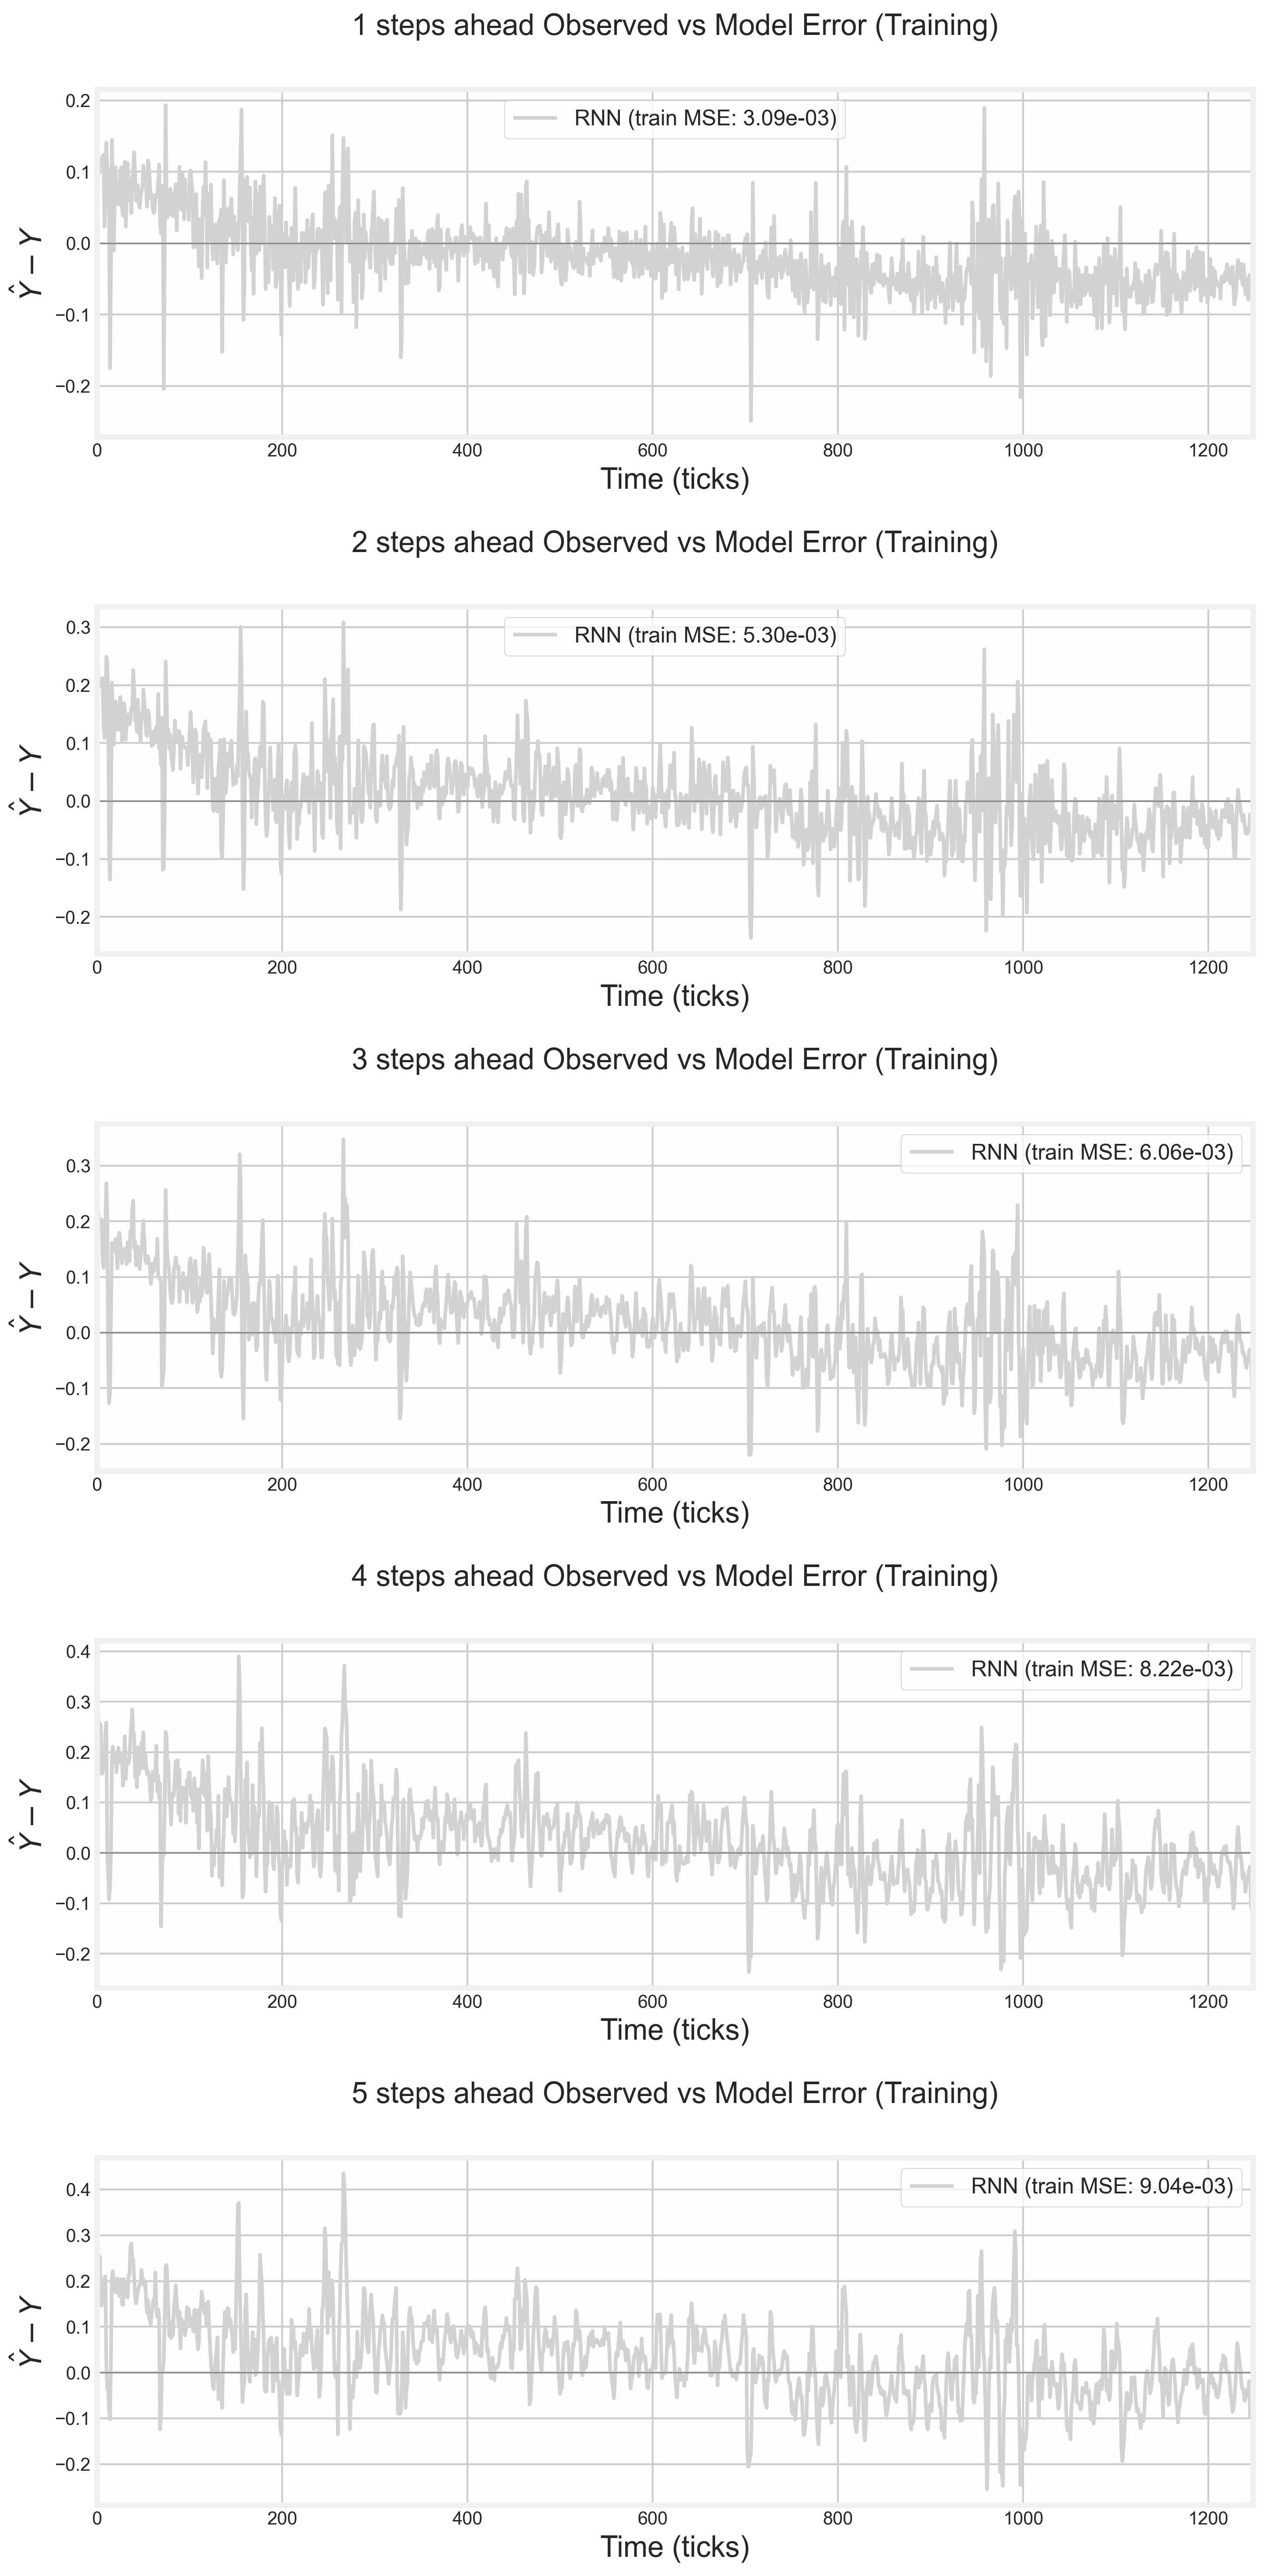

In [35]:
title_train = 'steps ahead Observed vs Model Error (Training)'
plotting.error_plot_timeline(
    compare, params, n_steps_ahead, y_train, y_test, title=title_train, trainplot=True)

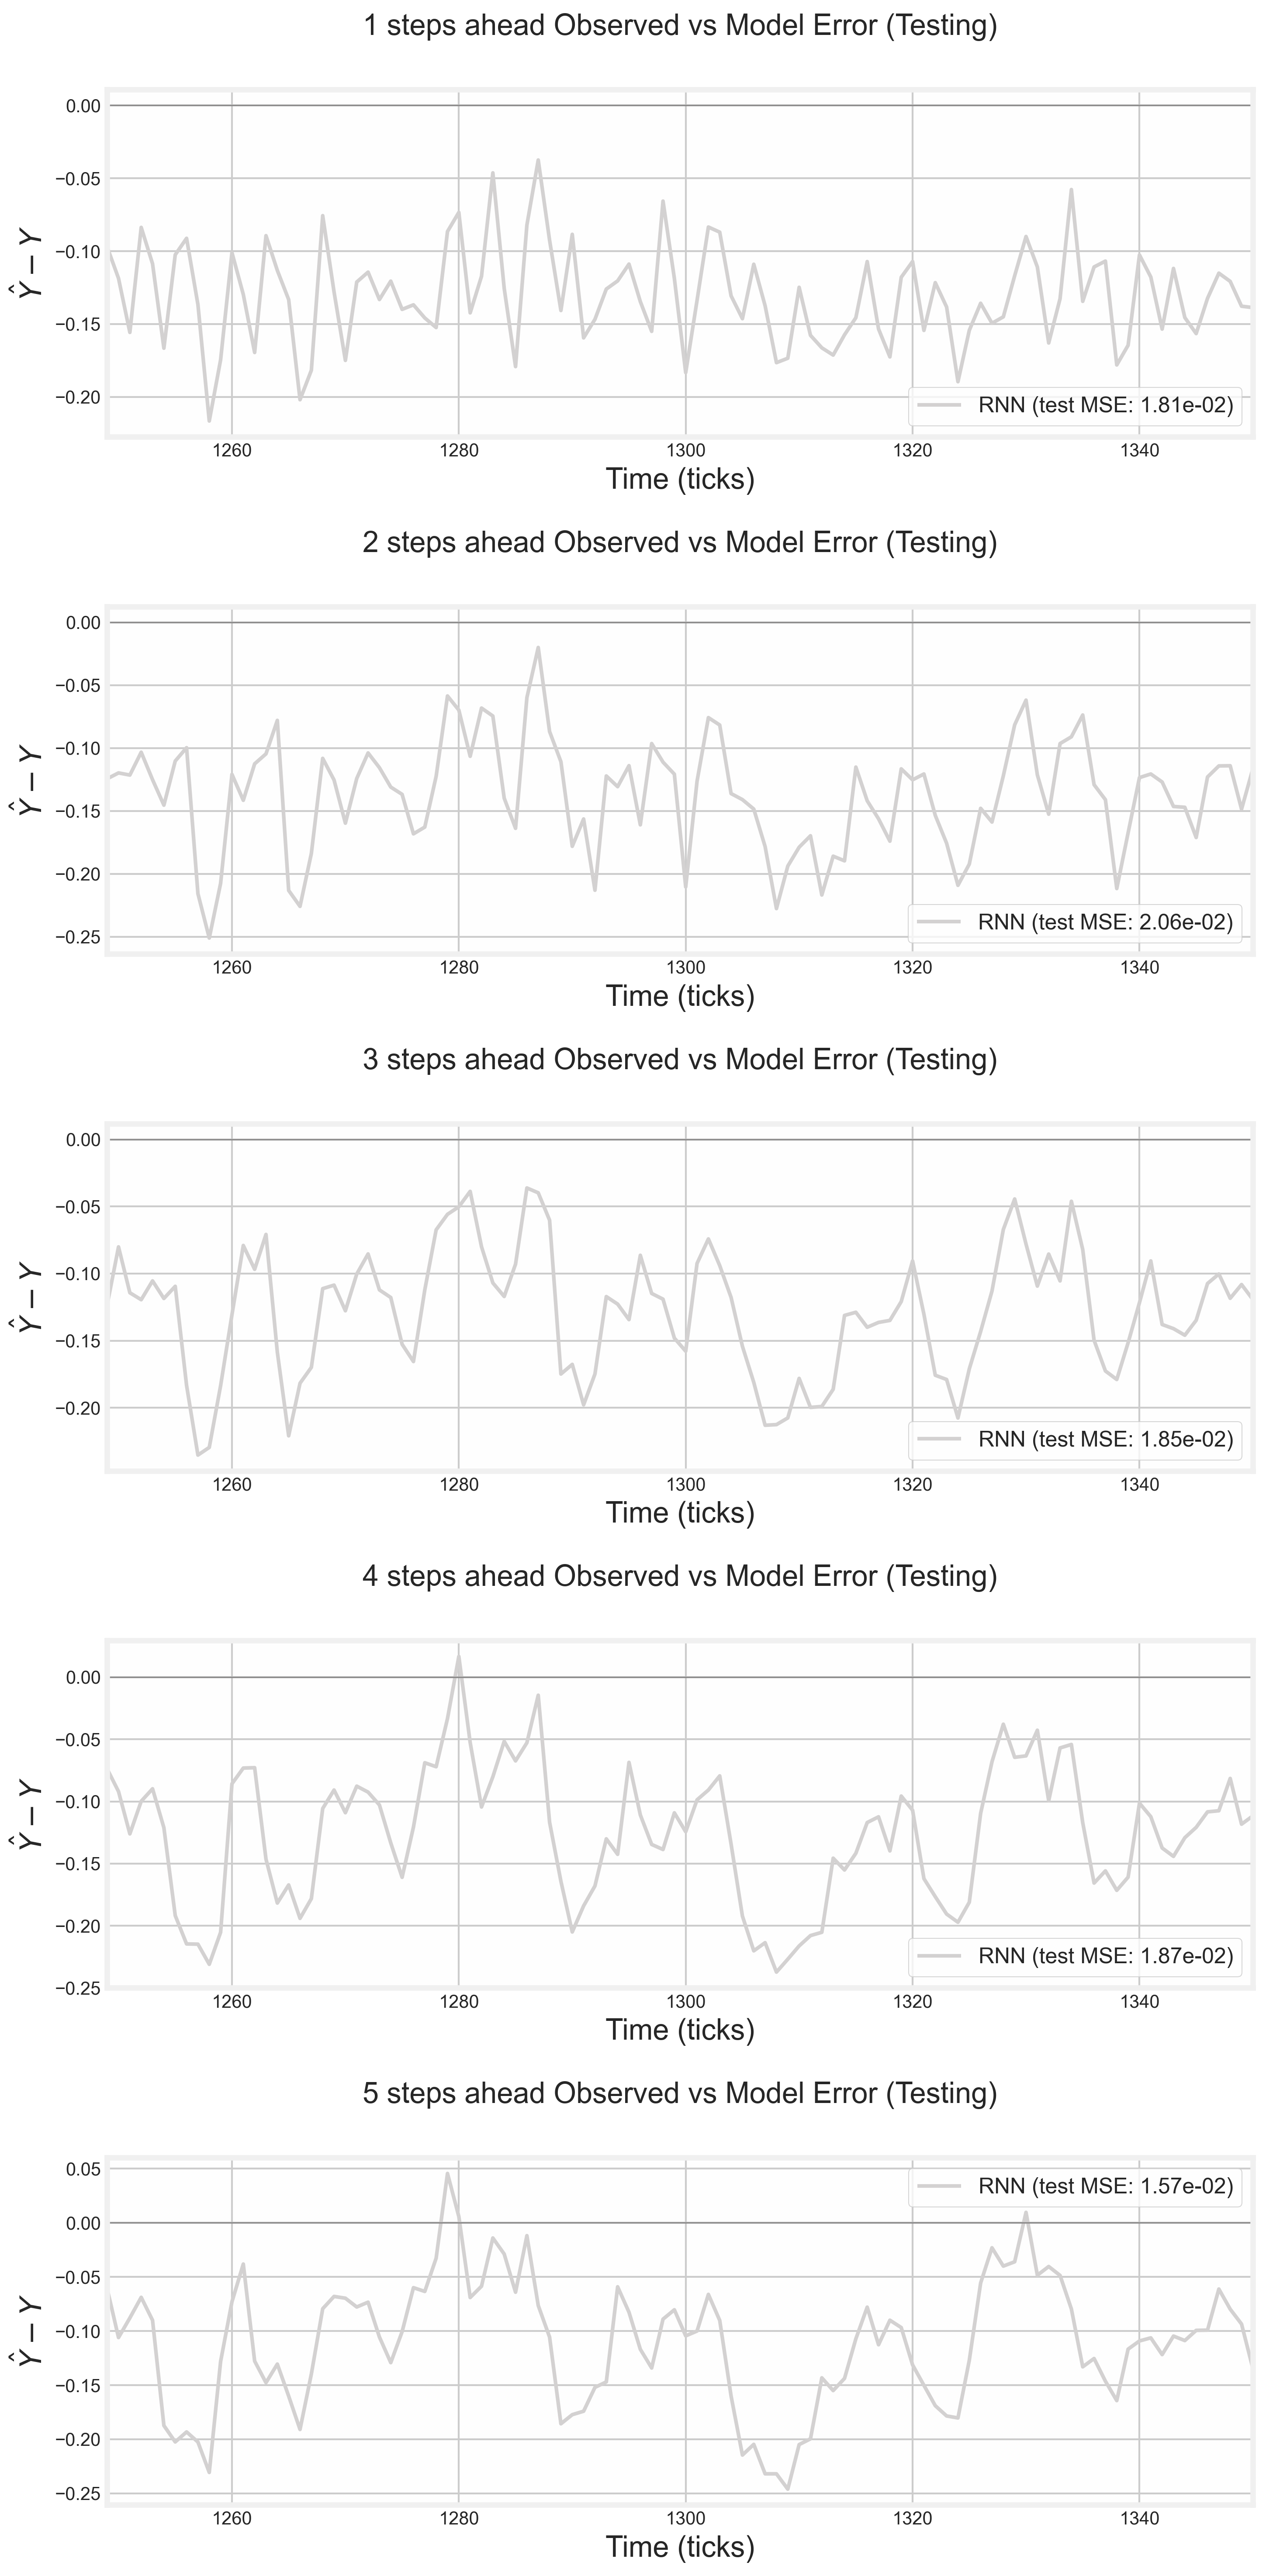

In [36]:
title_test = 'steps ahead Observed vs Model Error (Testing)'
plotting.error_plot_timeline(
    compare, params, n_steps_ahead, y_train, y_test, title=title_test, trainplot=False)

[-2.8124399820395674, -3.366748063849948, -2.9337988722482344, -2.9656969107292546, -2.3512033155745176]


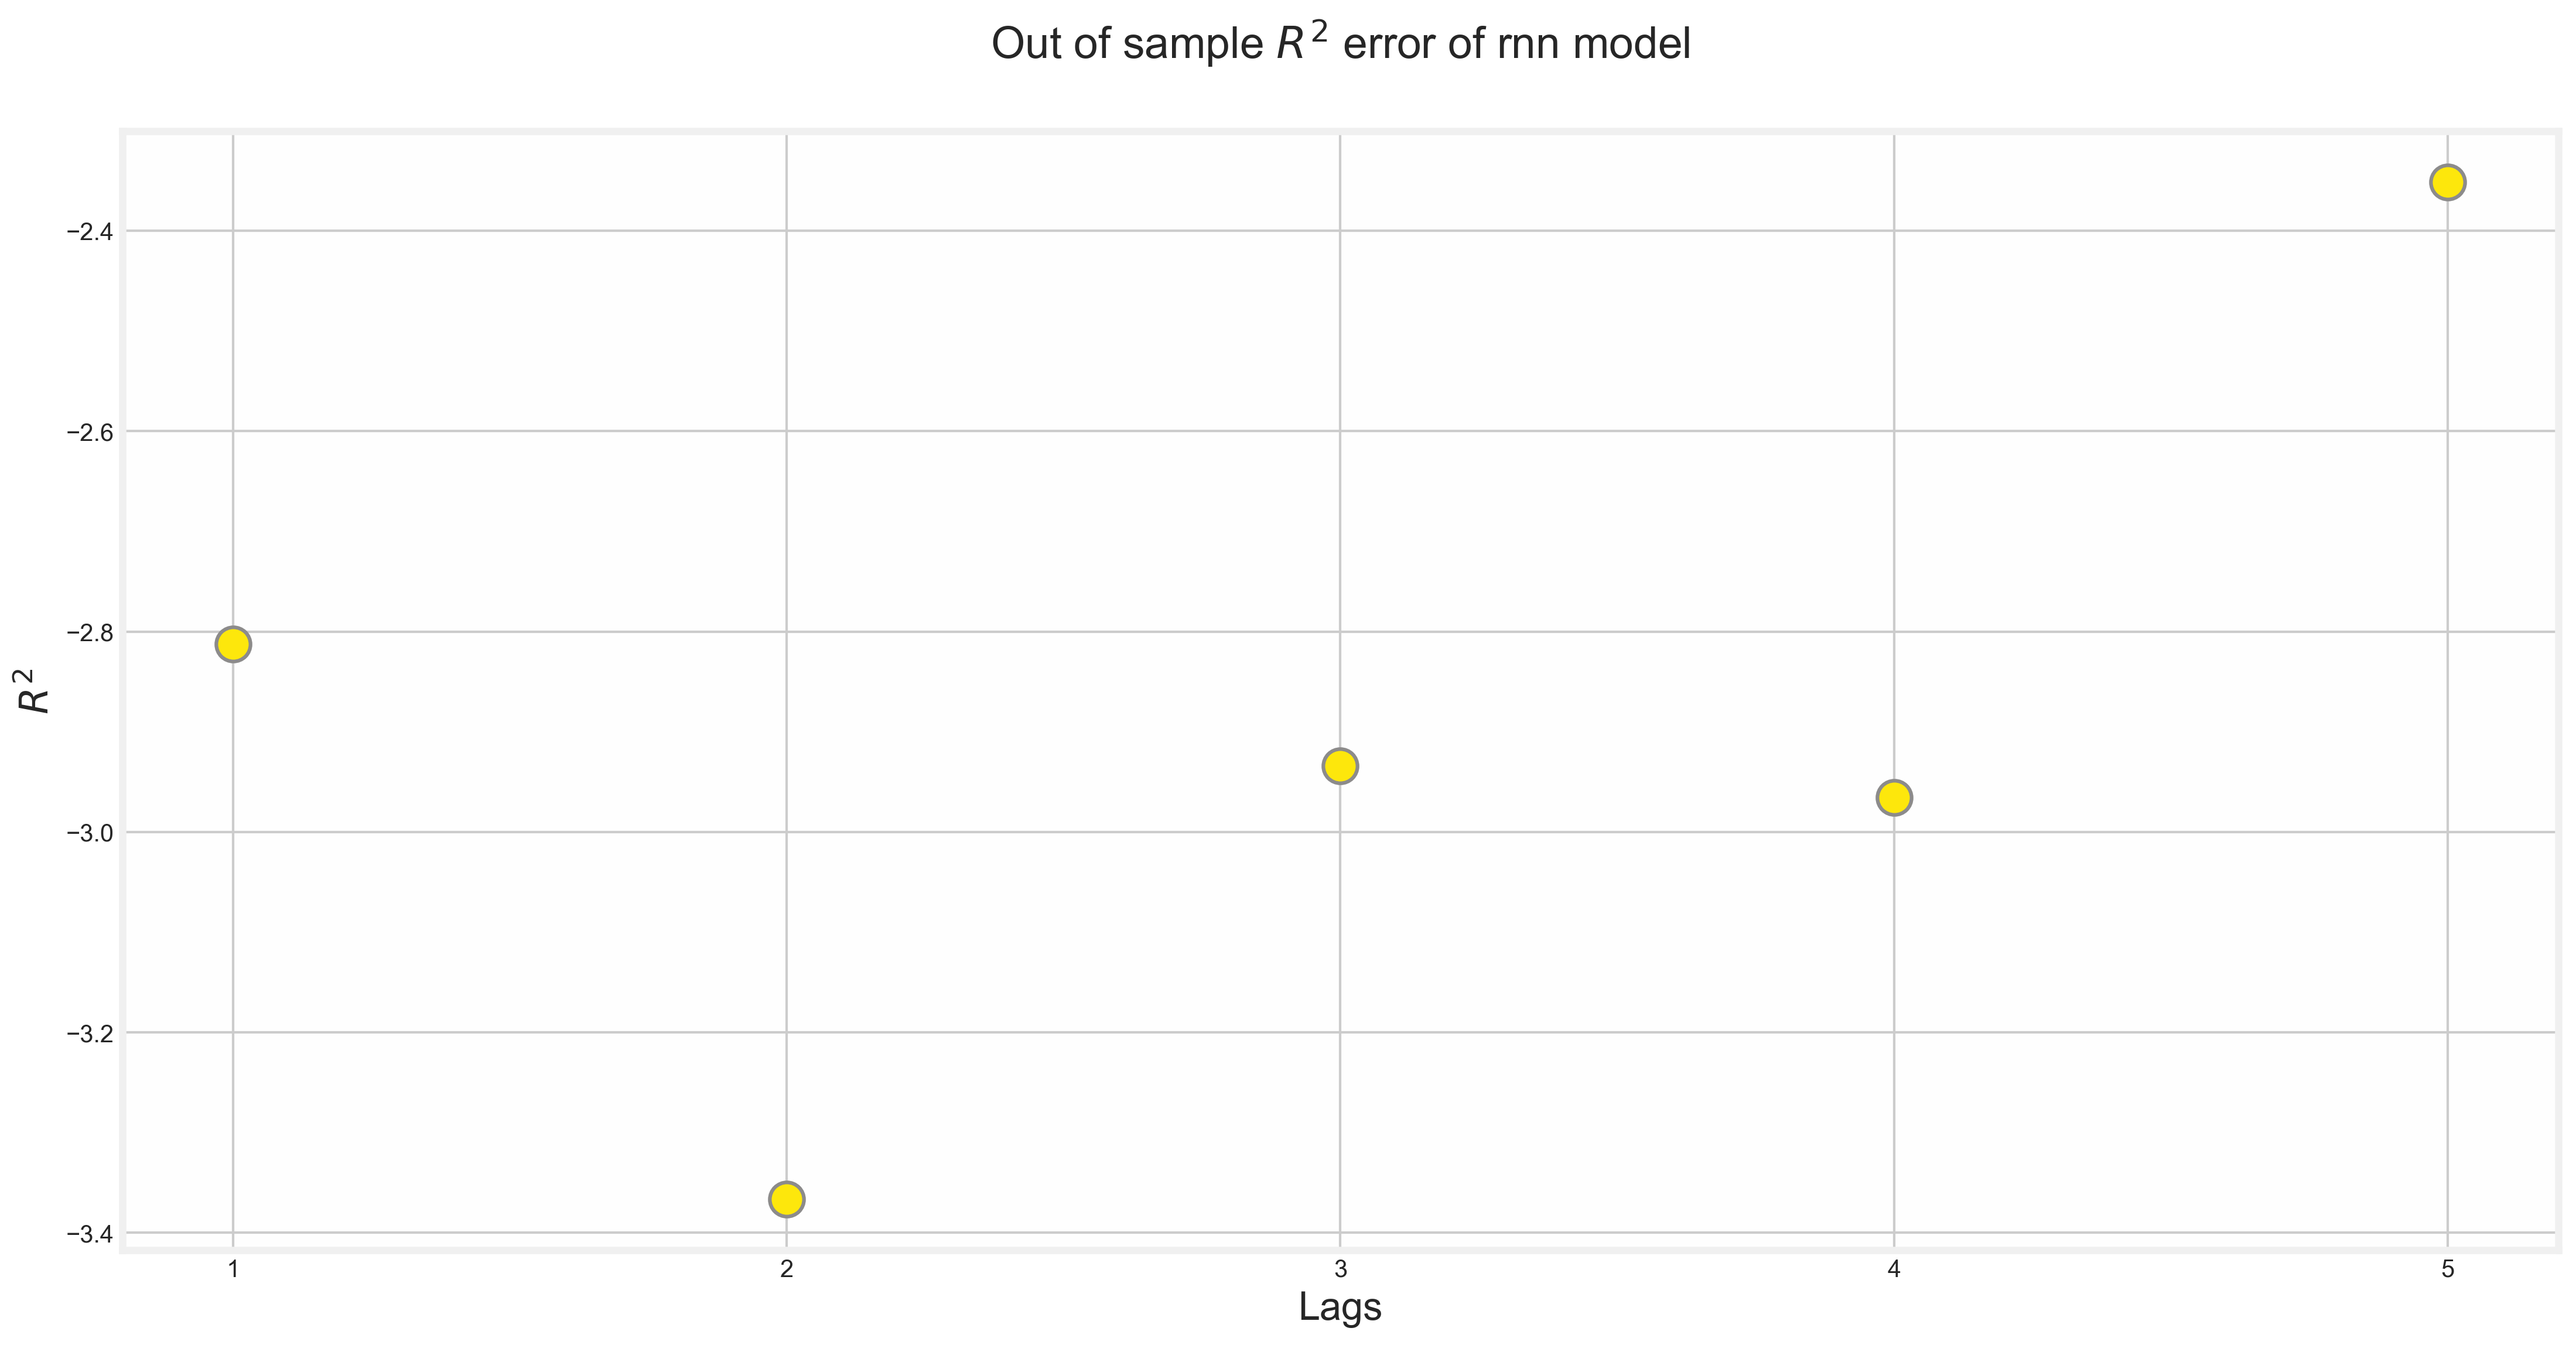

In [37]:
for key in compare:
    plt.figure(figsize=(15, 8))
    title = 'Out of sample $R^2$ error of ' + key + ' model'
    plotting.r2_error_plot(
        y_test, params[key]['pred_test'], n_steps_ahead, title)

[0.01808555583662695, 0.020629731628817198, 0.018540504980382965, 0.018678001876313622, 0.0156675136316279]


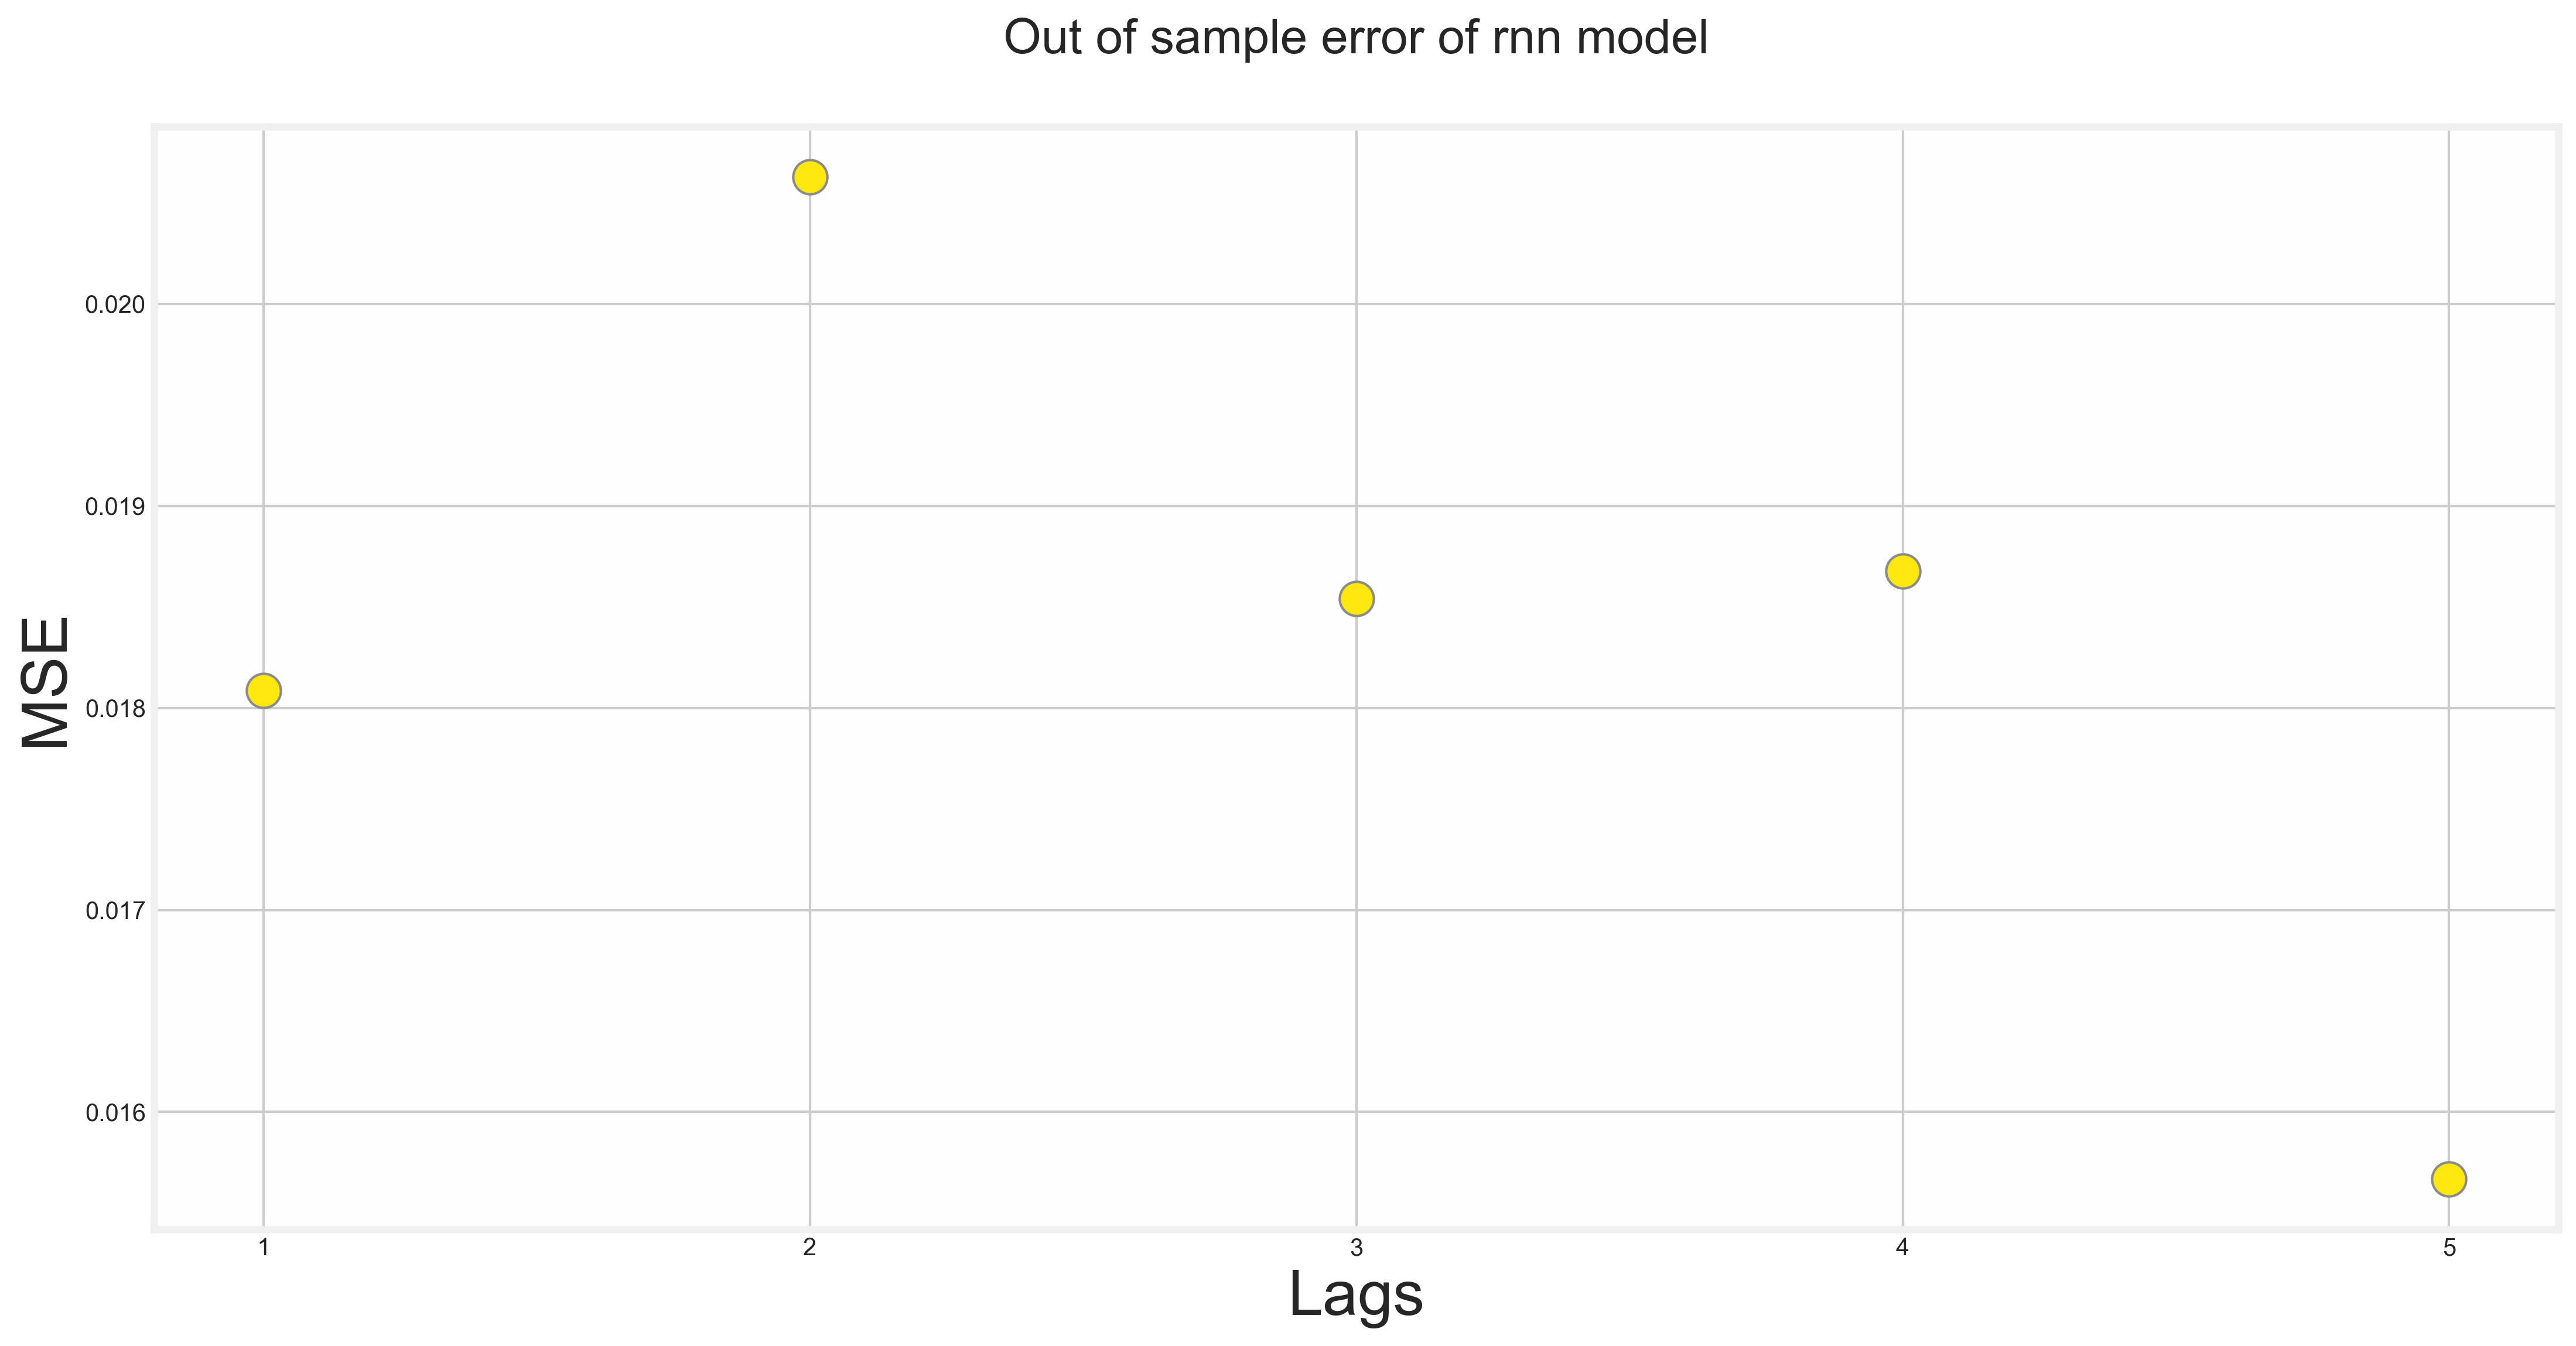

In [38]:
for key in compare:
    plt.figure(figsize=(15, 8))
    title = 'Out of sample error of ' + key + ' model'
    plotting.error_plot(y_test, params[key]['pred_test'], n_steps_ahead, title)

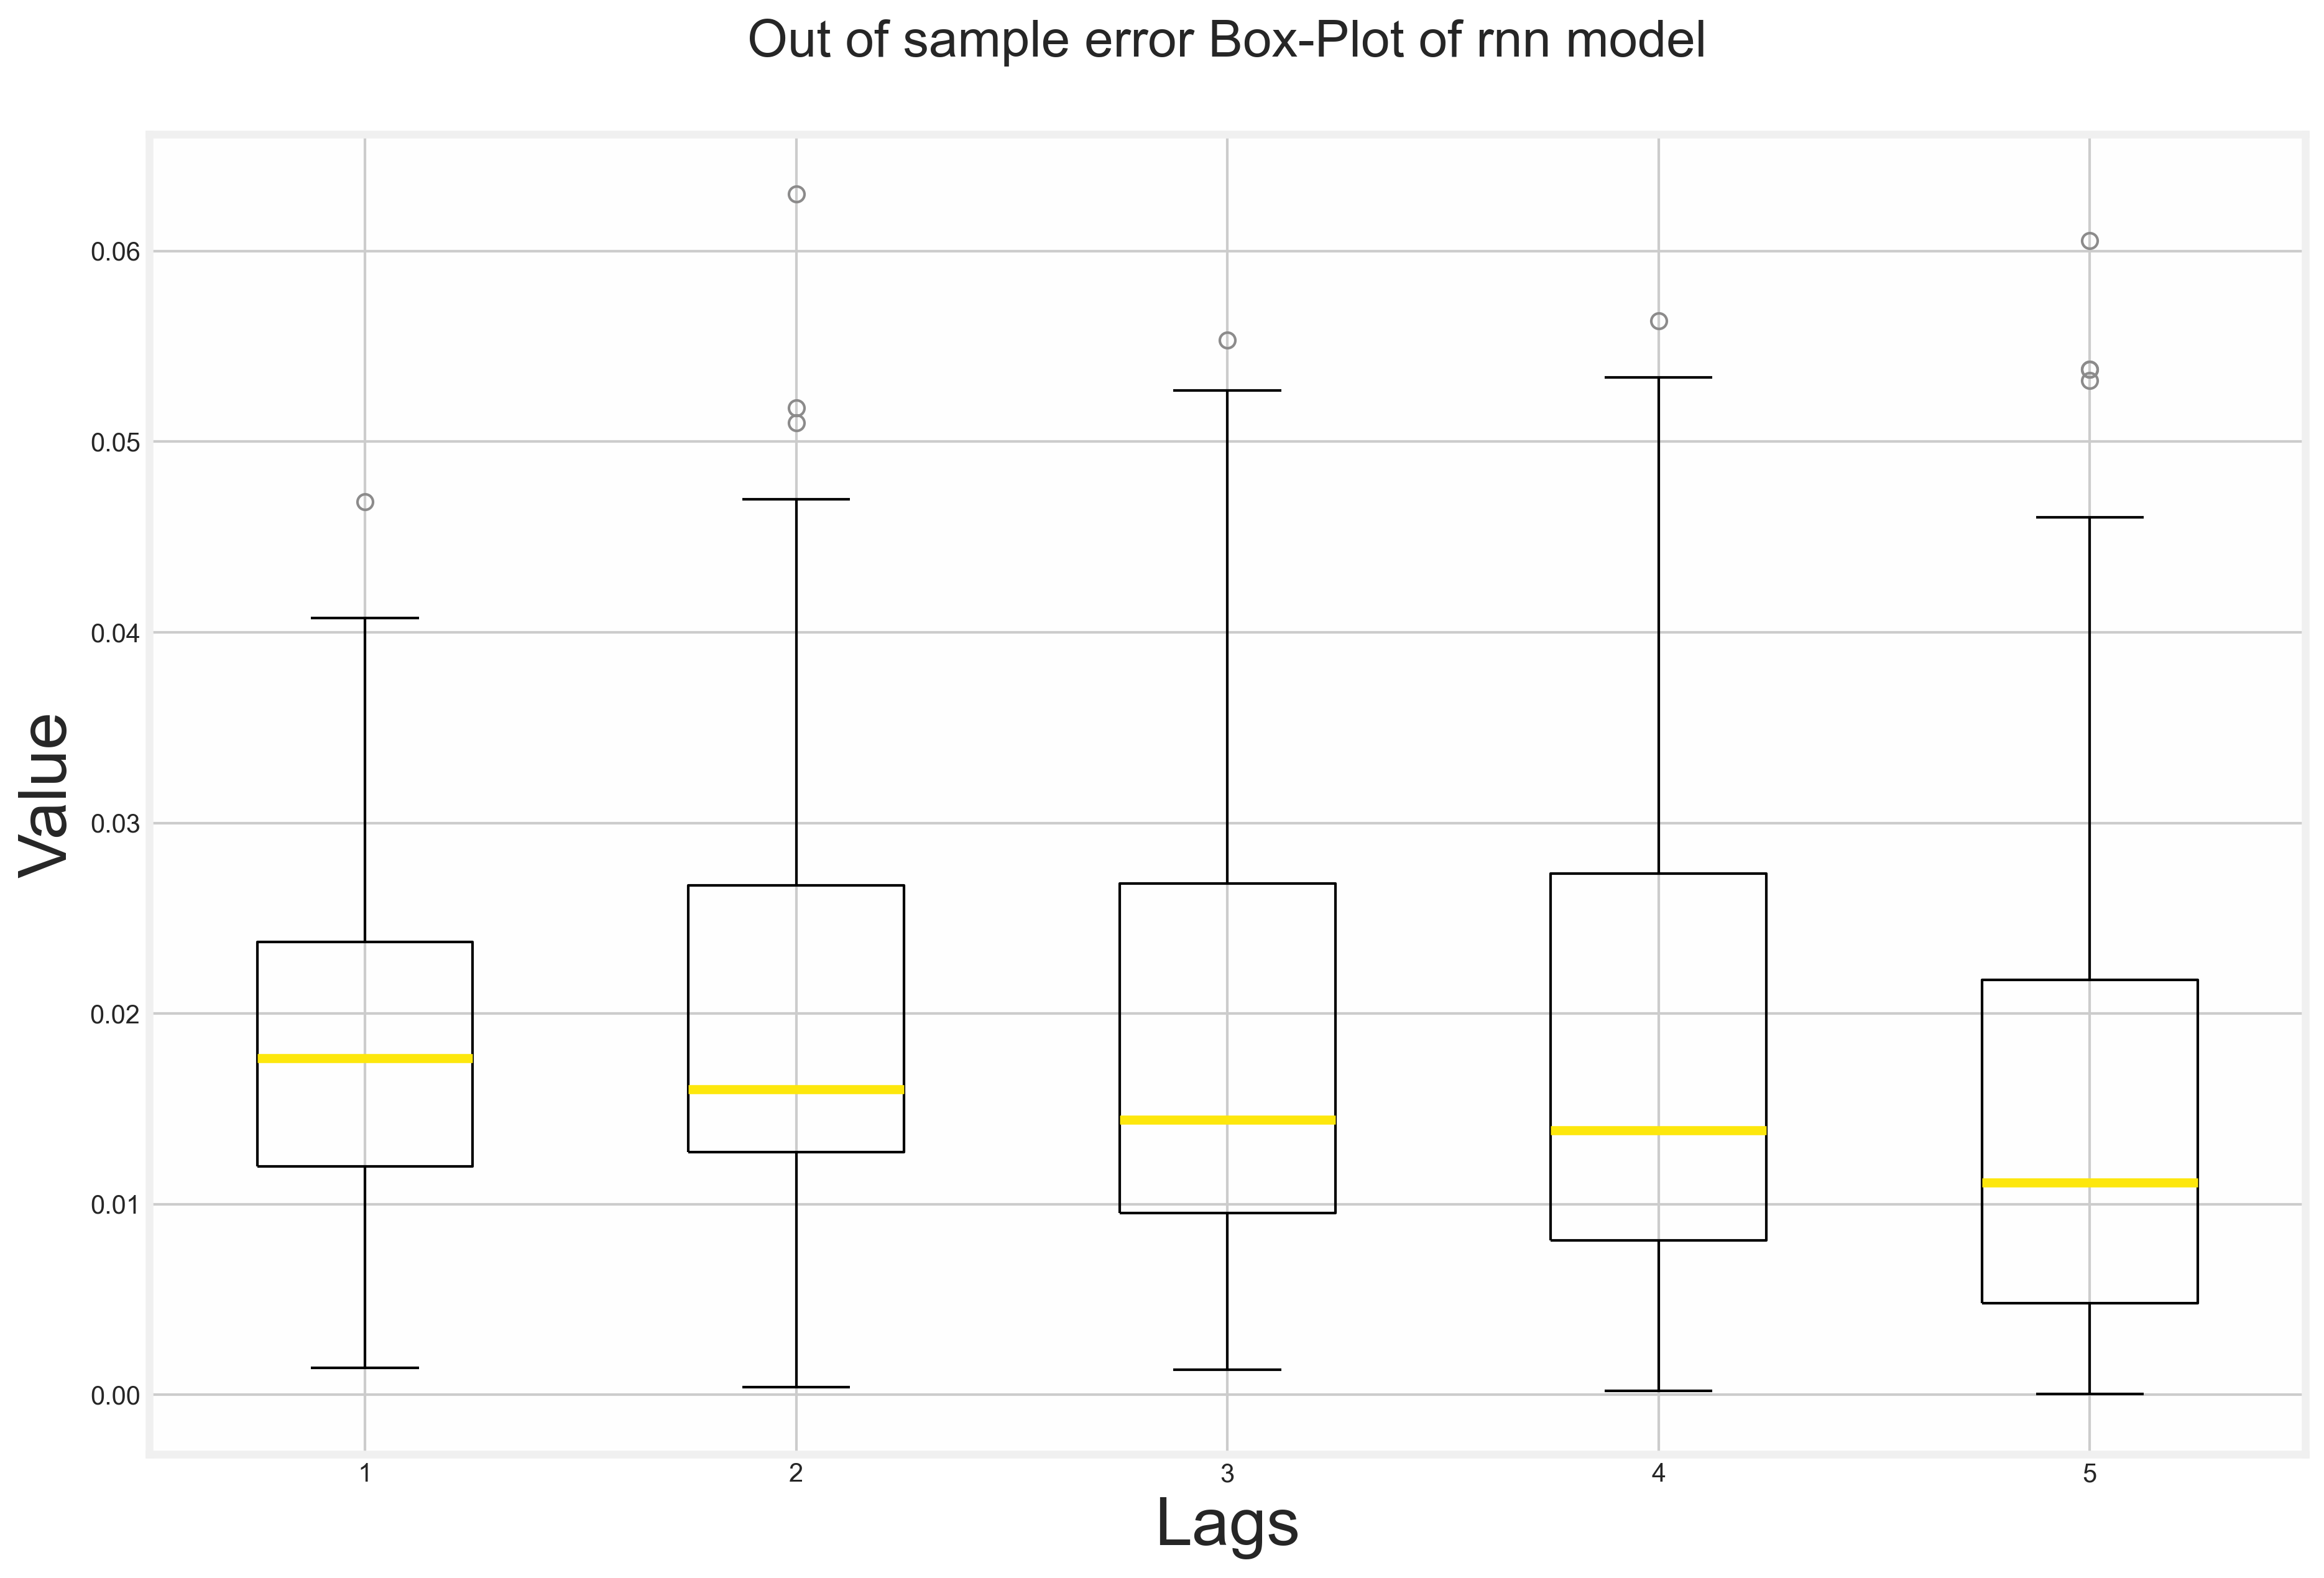

In [39]:
for key in compare:
    title = 'Out of sample error Box-Plot of ' + key + ' model'
    plotting.error_boxplot(
        y_test, params[key]['pred_test'], n_steps_ahead, title)

# Model Diagnostics

## Evaluate model

To gain more insights about the overall performance of the model, we use tensorflow's `evaluate()` function. 

In [40]:
# store the model performance
model_performance = {}

lags = str(n_steps)

# init the names
if uni:
    performance_name_train = key + '_' + ticker + '_' + lags + '_train_price'
    performance_name_val = key + '_' + ticker + '_' + lags + '_val_price'
    performance_name_test = key + '_' + ticker + '_' + lags + '_test_price'

else:
    performance_name_train = key + '_' + ticker + '_' + lags + '_train_conv_price'
    performance_name_val = key + '_' + ticker + '_' + lags + '_val_conv_price'
    performance_name_test = key + '_' + ticker + '_' + lags + '_test_conv_price'

# eval the model
for key in params.keys():
    model = params[key]['model']
    
    model_performance[performance_name_train] = model.evaluate(x_train, y_train)
    model_performance[performance_name_val] = model.evaluate(x_val, y_val)
    model_performance[performance_name_test] = model.evaluate(x_test, y_test)

    
metrics_evaluate = ma.get_eval_df(model_performance)
metrics_evaluate

4/4 [==============================] - 0s 1ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.1267


MSE        MAE
rnn_AMZN_5_train_conv_price 0.00634103 0.06025157
rnn_AMZN_5_val_conv_price   0.01961962 0.12567116
rnn_AMZN_5_test_conv_price  0.01832026 0.12667012

In [41]:
# save the date frame
evaluate_path = '../model_evaluate/'
evaluate_folder = '{}/'.format(ticker)

if uni: 
    evaluate_file_name = '_evaluate_df-price-{}-{}-n_steps.csv'.format(ticker, n_steps)

else: 
    evaluate_file_name = '_evaluate_df-price_conv-{}-{}-n_steps.csv'.format(ticker, n_steps)


metrics_evaluate.to_csv(evaluate_path + evaluate_folder + key + evaluate_file_name)

## Grid search 

In [42]:
# create df of model scores ordered by perfomance
model_scores = results_df.filter(regex=r'split\d*_test_score')

In [43]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores
tscv = TimeSeriesSplit(n_splits=5)

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(tscv.split(x_train, y_train))[0][0])
n_test = len(list(tscv.split(x_train, y_train))[0][1])

t_stat, p_val = ma.compute_corrected_ttest(differences, df, n_train, n_test)
print(f"Corrected t-value: {t_stat:.3f}\n"
      f"Corrected p-value: {p_val:.3f}")

Corrected t-value: 0.078
Corrected p-value: 0.471


In [44]:
t_stat_uncorrected = (
    np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
)
p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

print(f"Uncorrected t-value: {t_stat_uncorrected:.3f}\n"
      f"Uncorrected p-value: {p_val_uncorrected:.3f}")


Uncorrected t-value: 0.174
Uncorrected p-value: 0.435


In [45]:
# intitialize random variable
t_post = t(
    df, loc=np.mean(differences),
    scale=ma.corrected_std(differences, n_train, n_test)
)

Saving figure:  post_dist_plot_price_conv_AMZN_n_steps_5_n_steps_ahead_5


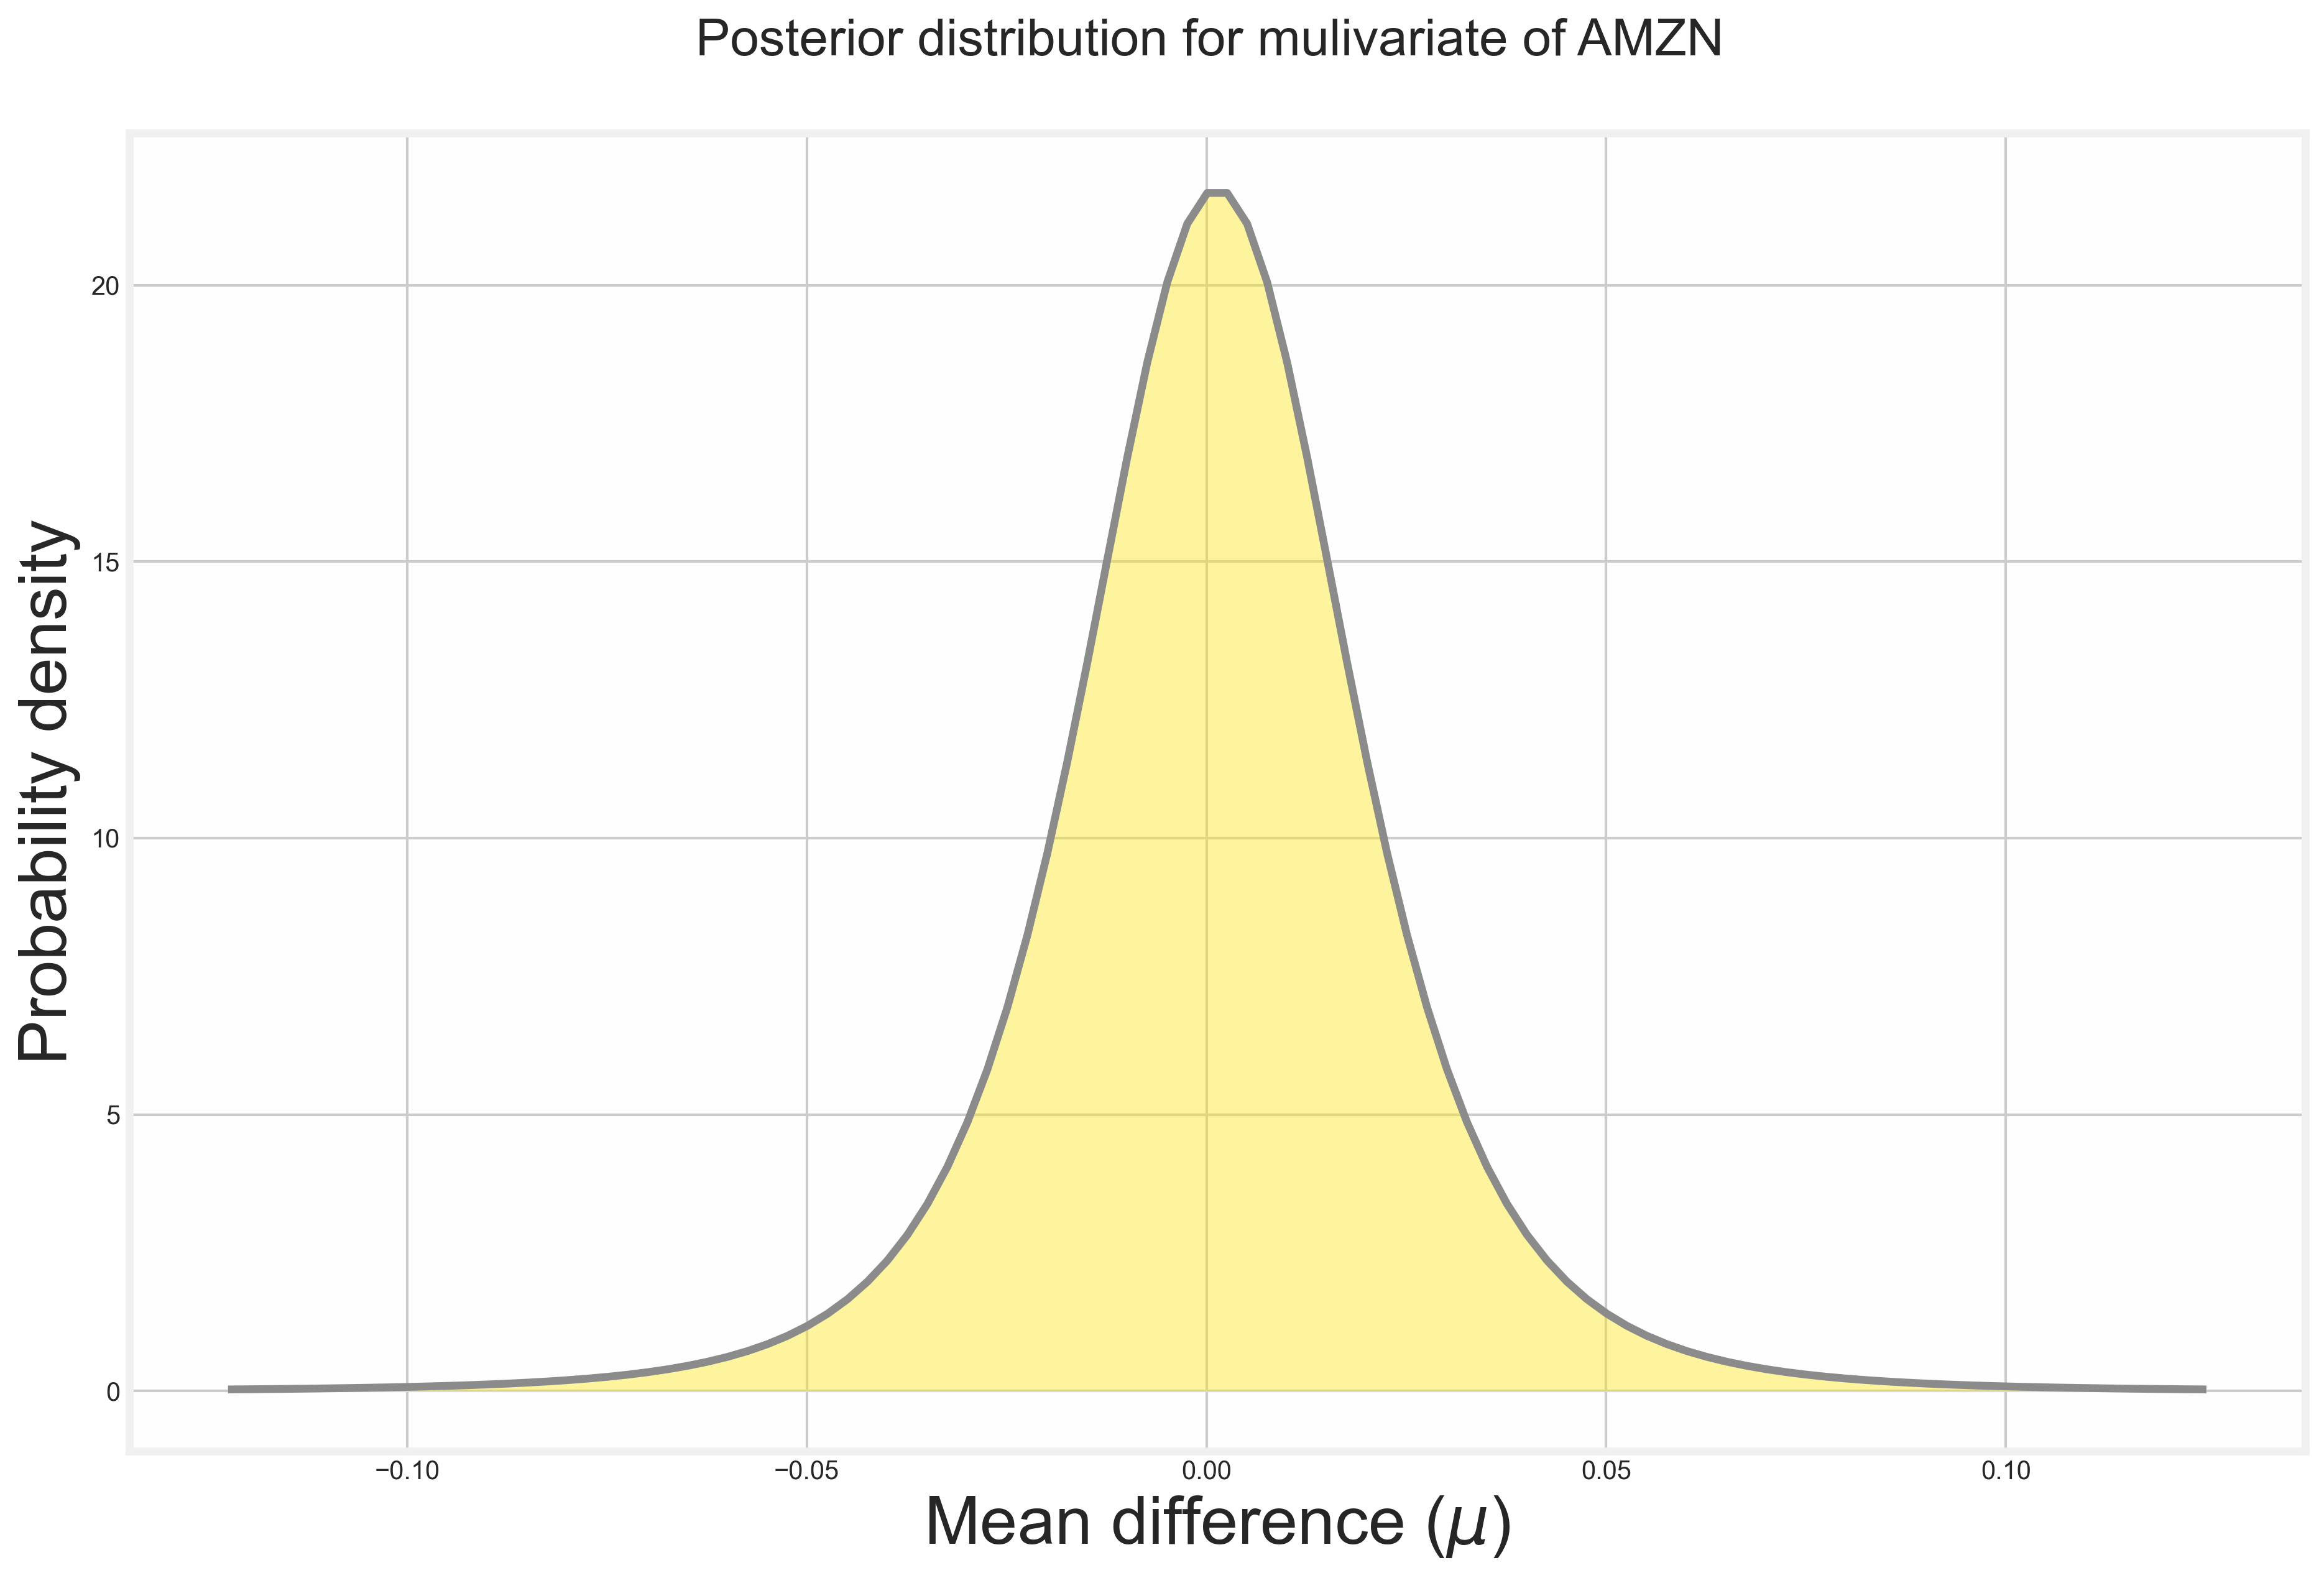

In [46]:
plotting.plot_post_distribution(t_post, ticker, n_steps, n_steps_ahead,uni)

In [47]:
better_prob = 1 - t_post.cdf(0)

print(f"Probability of model {model_scores.index[0]} being more accurate than "
      f"{model_scores.index[1]}: {better_prob:.3f}")
print(f"Probability of model {model_scores.index[1]} being more accurate than "
      f"{model_scores.index[0]}: {1 - better_prob:.3f}")

Probability of model 0 being more accurate than 1: 0.529
Probability of model 1 being more accurate than 0: 0.471


Saving figure:  Histogramm_plot_price_conv_AMZN_n_steps_5_n_steps_ahead_5


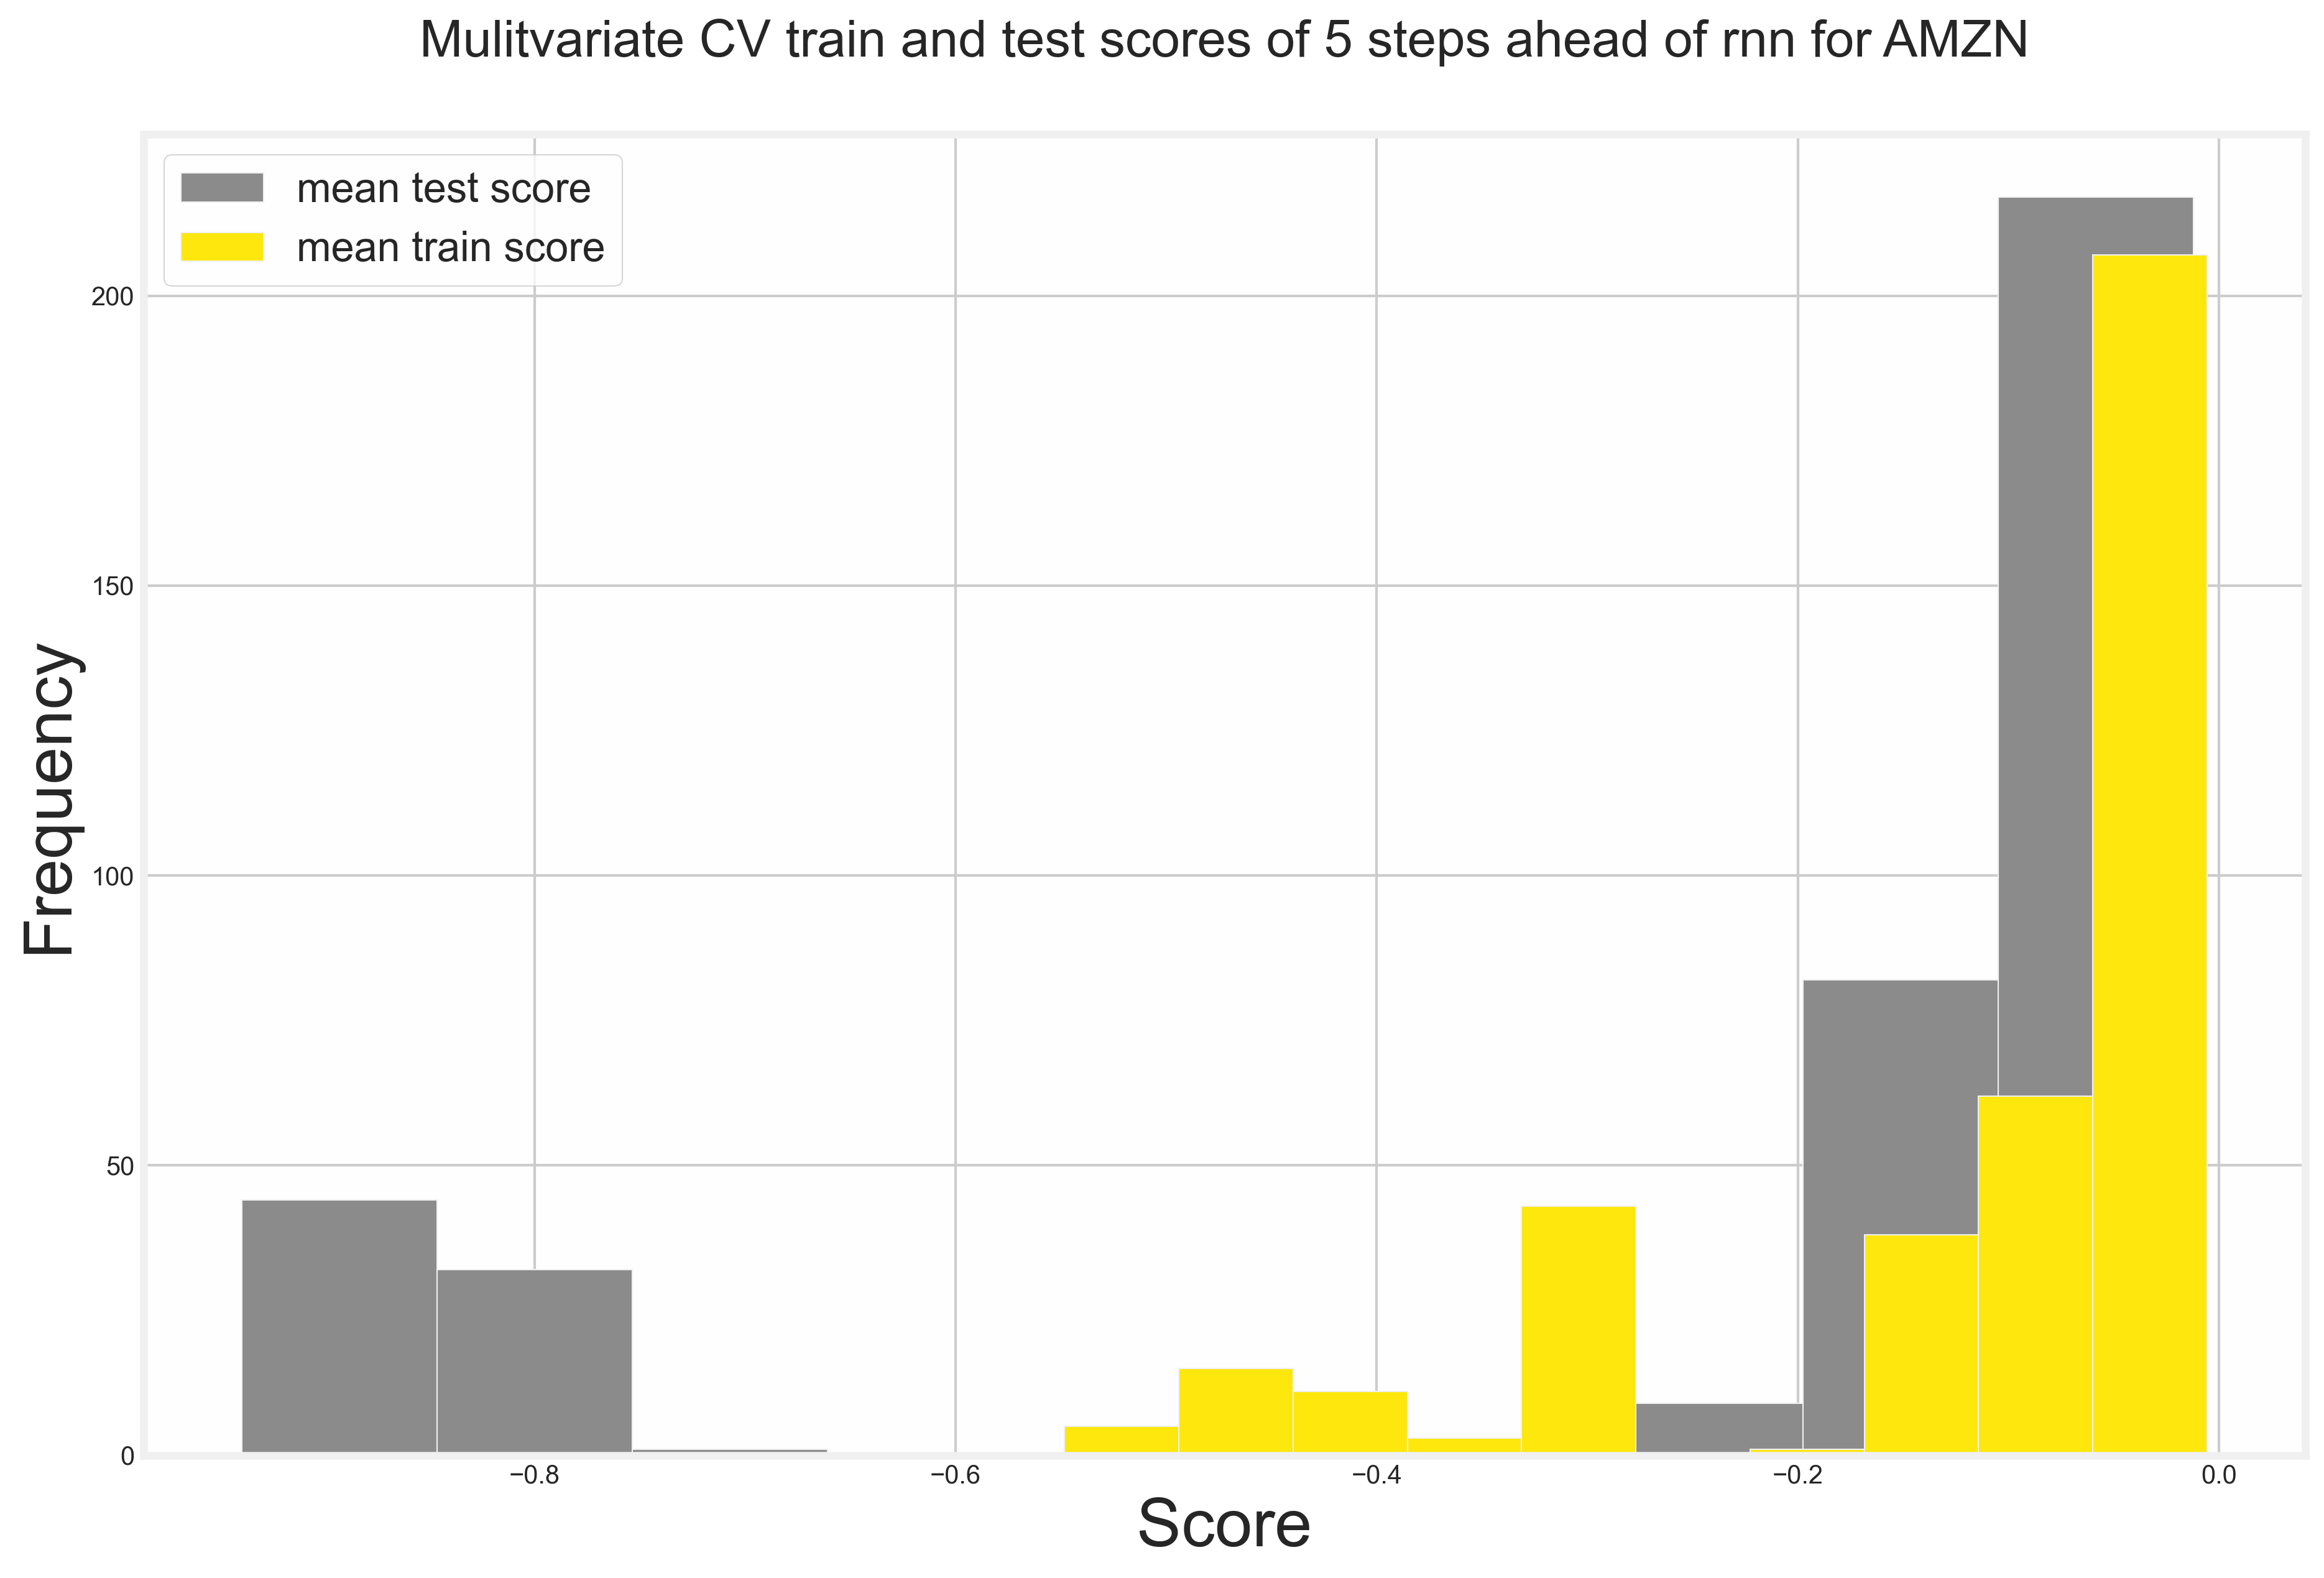

In [48]:
plotting.plot_CV_histogram(results_df, key, ticker, n_steps, n_steps_ahead, uni)

## Underfitting

In [49]:
predicted = params[key]['pred_test']

In [50]:
for i in range (n_steps_ahead):
    residual = y_test[:,i] - predicted[:,i]
    white_noise_test_df = ma.white_noise_test(residual, n_steps)
    print(white_noise_test_df)
    print('\n')
    print('='*22)

    LB-stats P-value
Lag                 
1     2.0539  0.1518
2    17.1384  0.0002
3    20.9037  0.0001
4    30.3021     0.0
5    31.1815     0.0


    LB-stats P-value
Lag                 
1    27.3927     0.0
2    28.2554     0.0
3    29.3525     0.0
4    29.9817     0.0
5    30.3659     0.0


    LB-stats P-value
Lag                 
1    55.1453     0.0
2    68.3827     0.0
3    68.4753     0.0
4    70.6073     0.0
5    71.2126     0.0


    LB-stats P-value
Lag                 
1     61.962     0.0
2    85.9776     0.0
3     92.591     0.0
4     92.832     0.0
5    93.8129     0.0


     LB-stats P-value
Lag                  
1     65.8032     0.0
2     97.4814     0.0
3    111.7181     0.0
4    116.6719     0.0
5    116.6952     0.0




In [51]:
residual = y_test[:,0] - predicted[:,0]
# perform Ljung-Box-Test to test for white noise, i.e. underfitting
white_noise_test_df = ma.white_noise_test(residual, n_steps)
white_noise_test_df

LB-stats P-value
Lag                 
1     2.0539  0.1518
2    17.1384  0.0002
3    20.9037  0.0001
4    30.3021     0.0
5    31.1815     0.0

In [52]:
analysis_path = '../model_analysis/'
analysis_folder = '{}/'.format(ticker)

if uni: 
    analysis_file_name = '_white_noise_df-price-{}-{}-n_steps.csv'.format(ticker, n_steps)

else: 
    analysis_file_name = '_white_noise_df-price_conv-{}-{}-n_steps.csv'.format(ticker, n_steps)


white_noise_test_df.to_csv(analysis_path + analysis_folder + key + analysis_file_name)

## Rescaled model metrics 

In [53]:
# get rescaled MAPE of 
metrics_df = ma.get_rescaled_mape_r2(y_test, predicted, mu, sigma, n_steps_ahead)
metrics_df

MAPE    $R^2$
lag                 
1    6.6406  -2.6112
2    6.9583  -3.1199
3    6.5231  -2.7284
4    6.4121  -2.7627
5    5.6991  -2.2029

In [54]:
analysis_path = '../model_analysis/'
analysis_folder = '{}/'.format(ticker)

if uni: 
    analysis_file_name = '_metrics_df-price-{}-{}-n_steps.csv'.format(ticker, n_steps)

else: 
    analysis_file_name = '_metrics_df-price_conv-{}-{}-n_steps.csv'.format(ticker, n_steps)


metrics_df.to_csv(analysis_path + analysis_folder + key + analysis_file_name)

In [55]:
from scipy.stats import pearsonr

pearsonr(y_test[:,0], predicted[:,0])

(0.8758427666332841, 2.068081878093747e-33)

In [56]:
from scipy import stats

In [57]:
observed = y_test[:,0]
residuals = predicted[:,0]
result = stats.ttest_ind(observed, residuals)[1]
print('P-value of 1 step ahead is: {}'.format(result))

P-value of 1 step ahead is: 8.272676207462329e-32


In [58]:
observed = y_test[:,4]
residuals = predicted[:,4]
result = stats.ttest_ind(observed, residuals)
print('P-value of 5 step ahead is: {}'.format(result))

P-value of 5 step ahead is: Ttest_indResult(statistic=11.824513150833543, pvalue=7.359970870905462e-25)


# Plot observed vs. predicted

Saving figure:  rnn_stock_price_plot_price_conv_AMZN_n_steps_5_n_steps_ahead_1
Saving figure:  rnn_stock_price_plot_price_conv_AMZN_n_steps_5_n_steps_ahead_2
Saving figure:  rnn_stock_price_plot_price_conv_AMZN_n_steps_5_n_steps_ahead_3
Saving figure:  rnn_stock_price_plot_price_conv_AMZN_n_steps_5_n_steps_ahead_4
Saving figure:  rnn_stock_price_plot_price_conv_AMZN_n_steps_5_n_steps_ahead_5


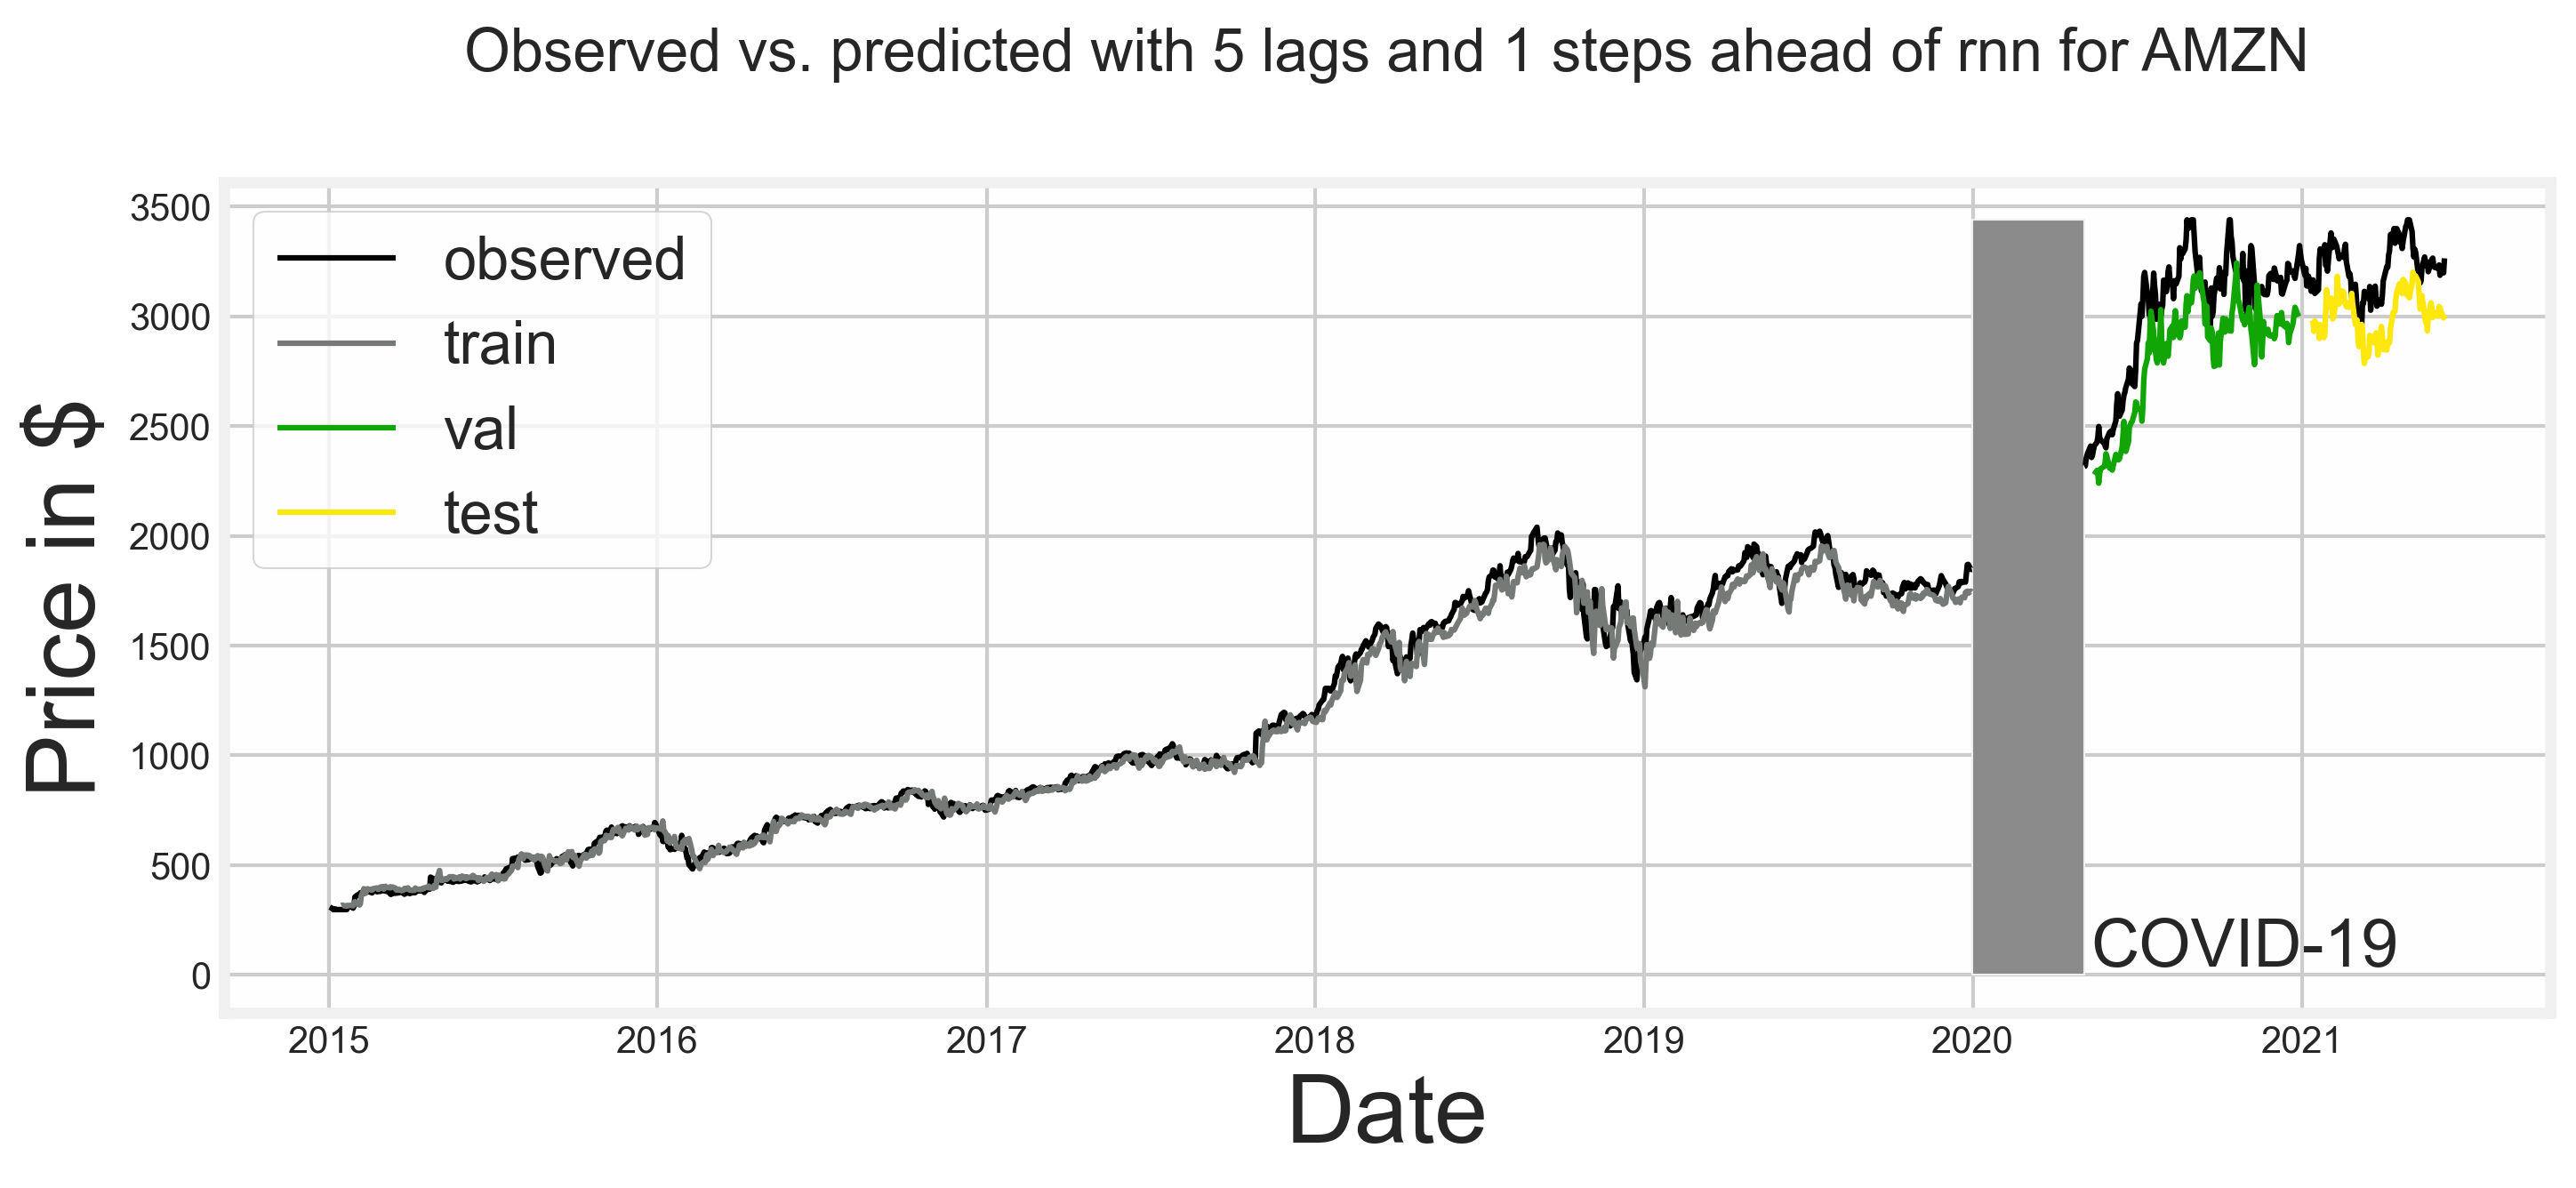

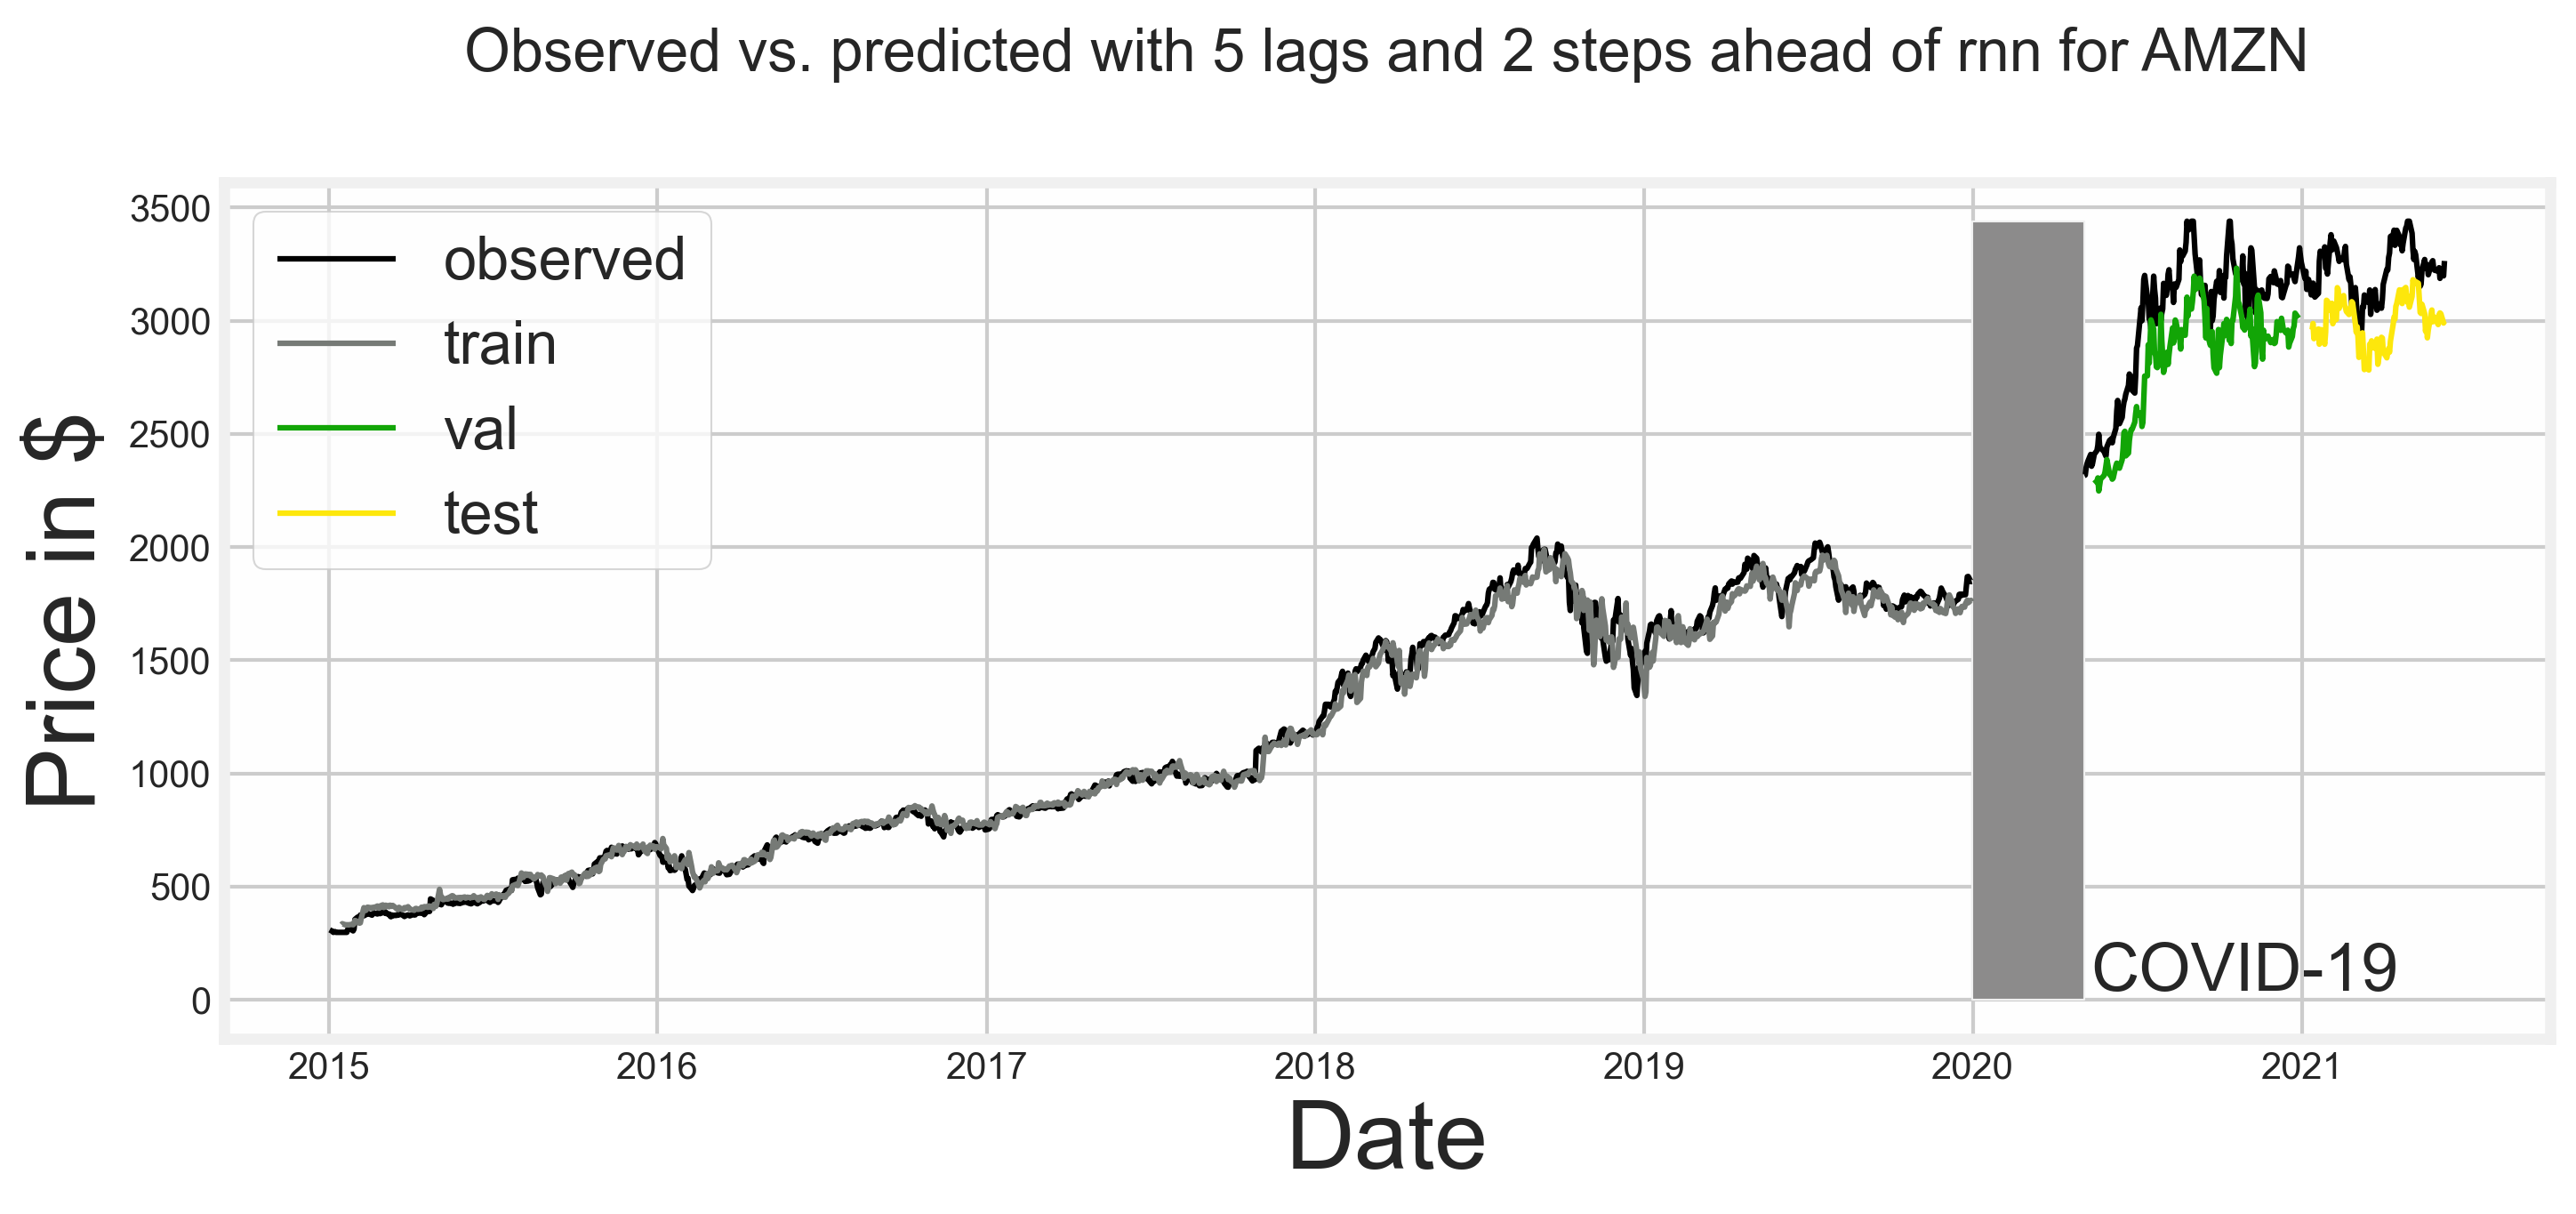

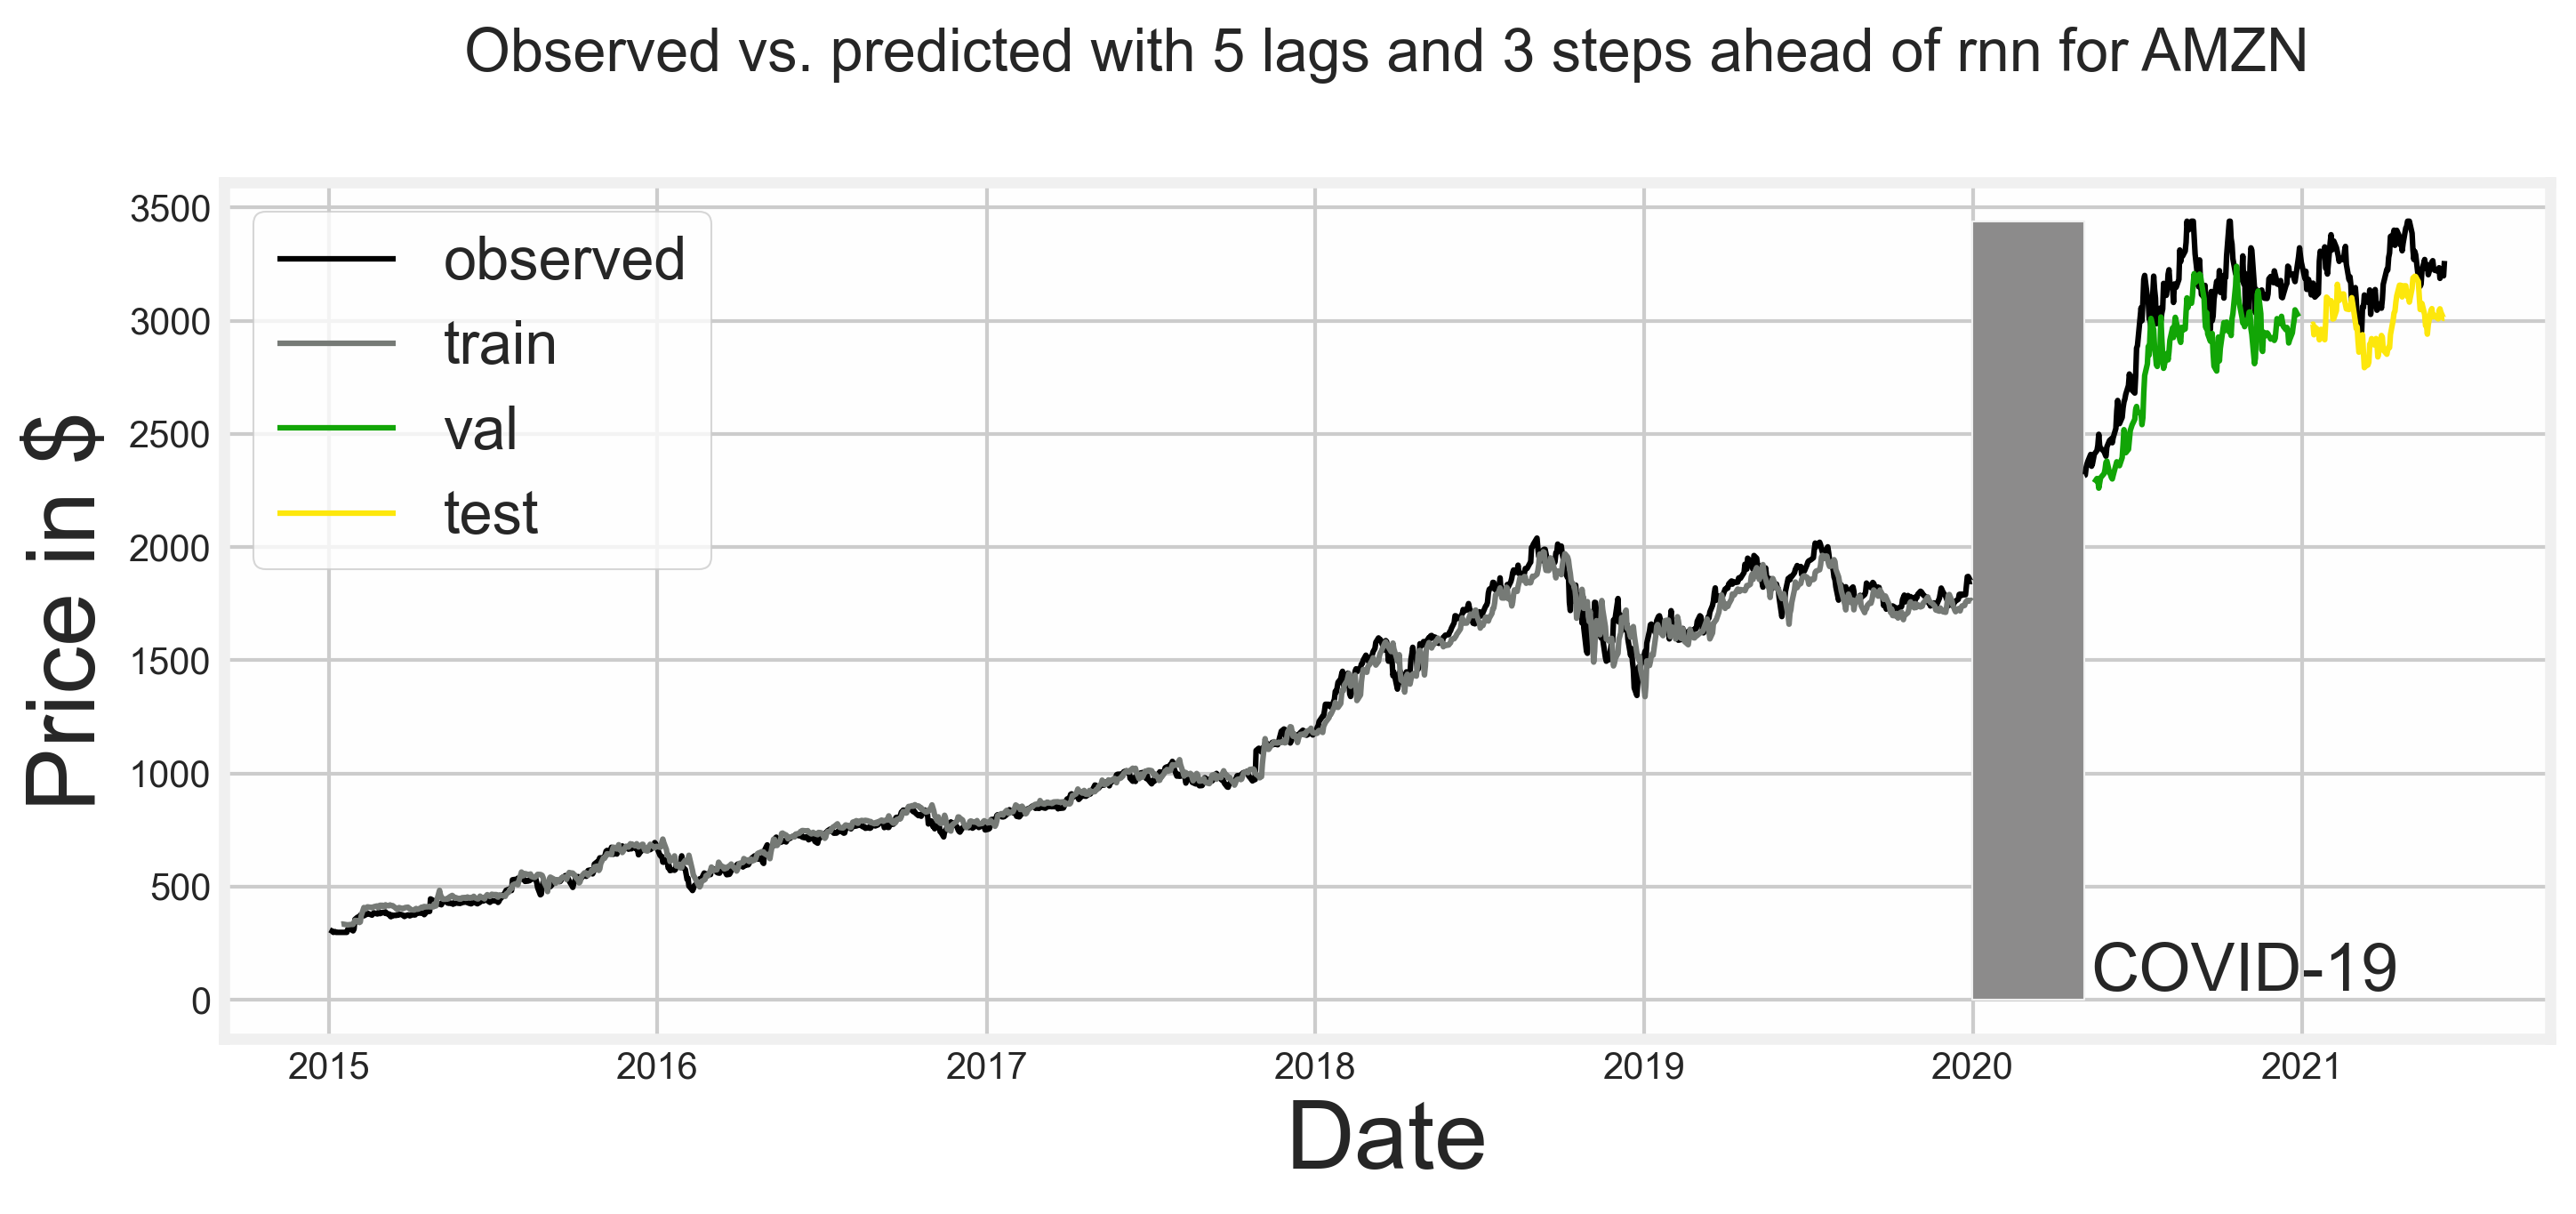

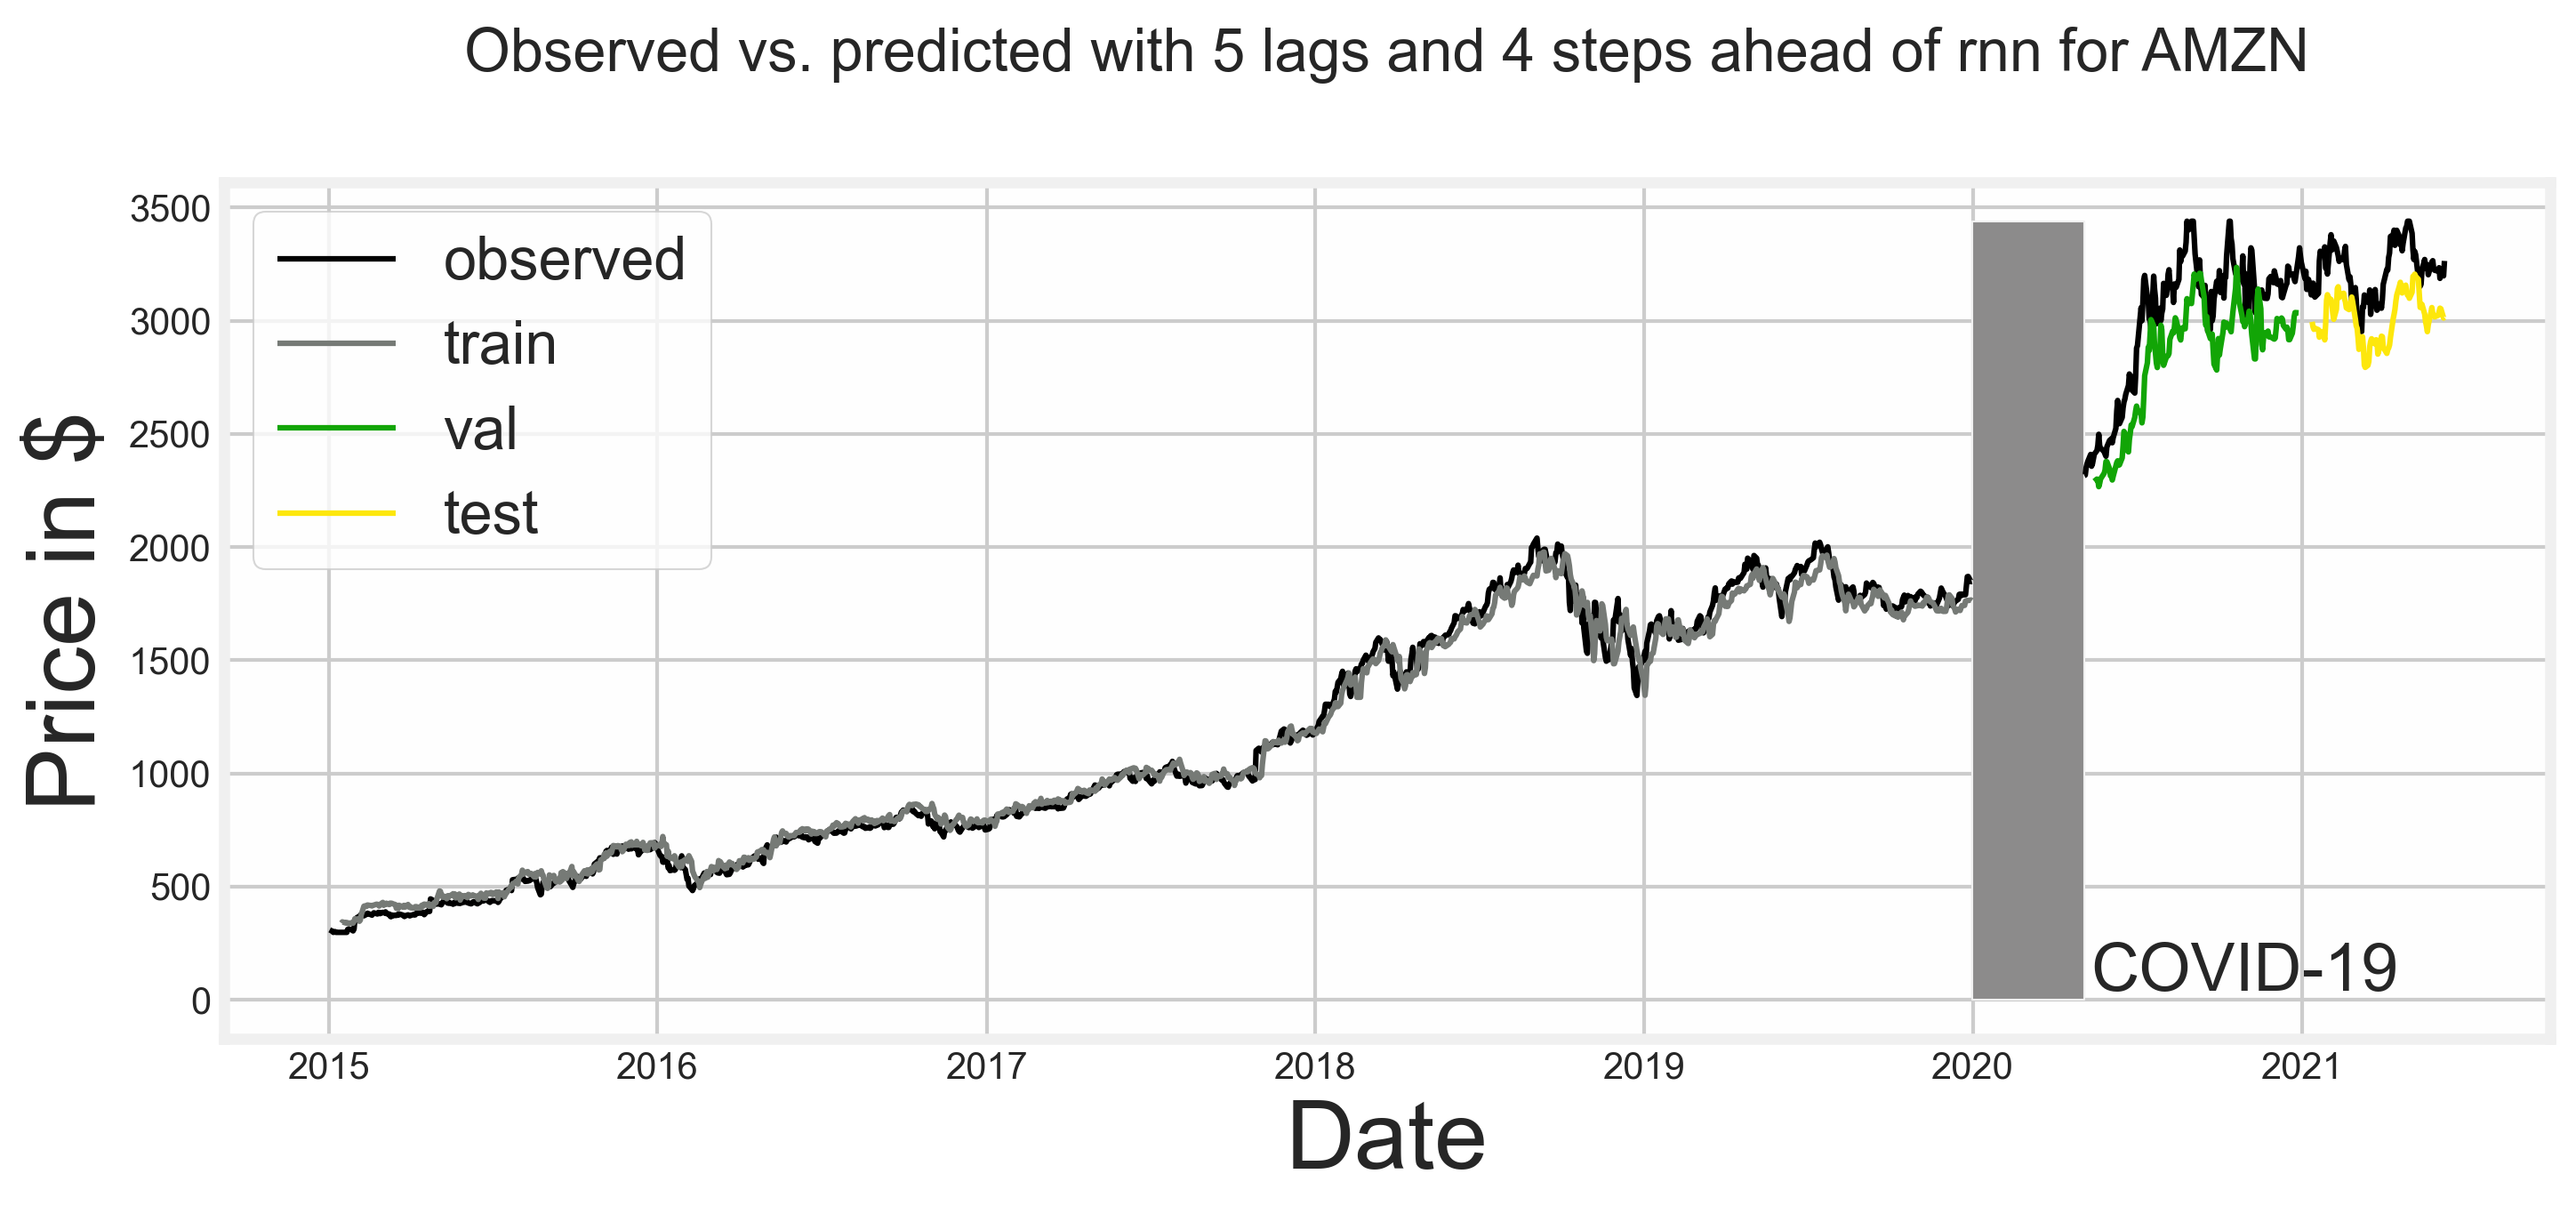

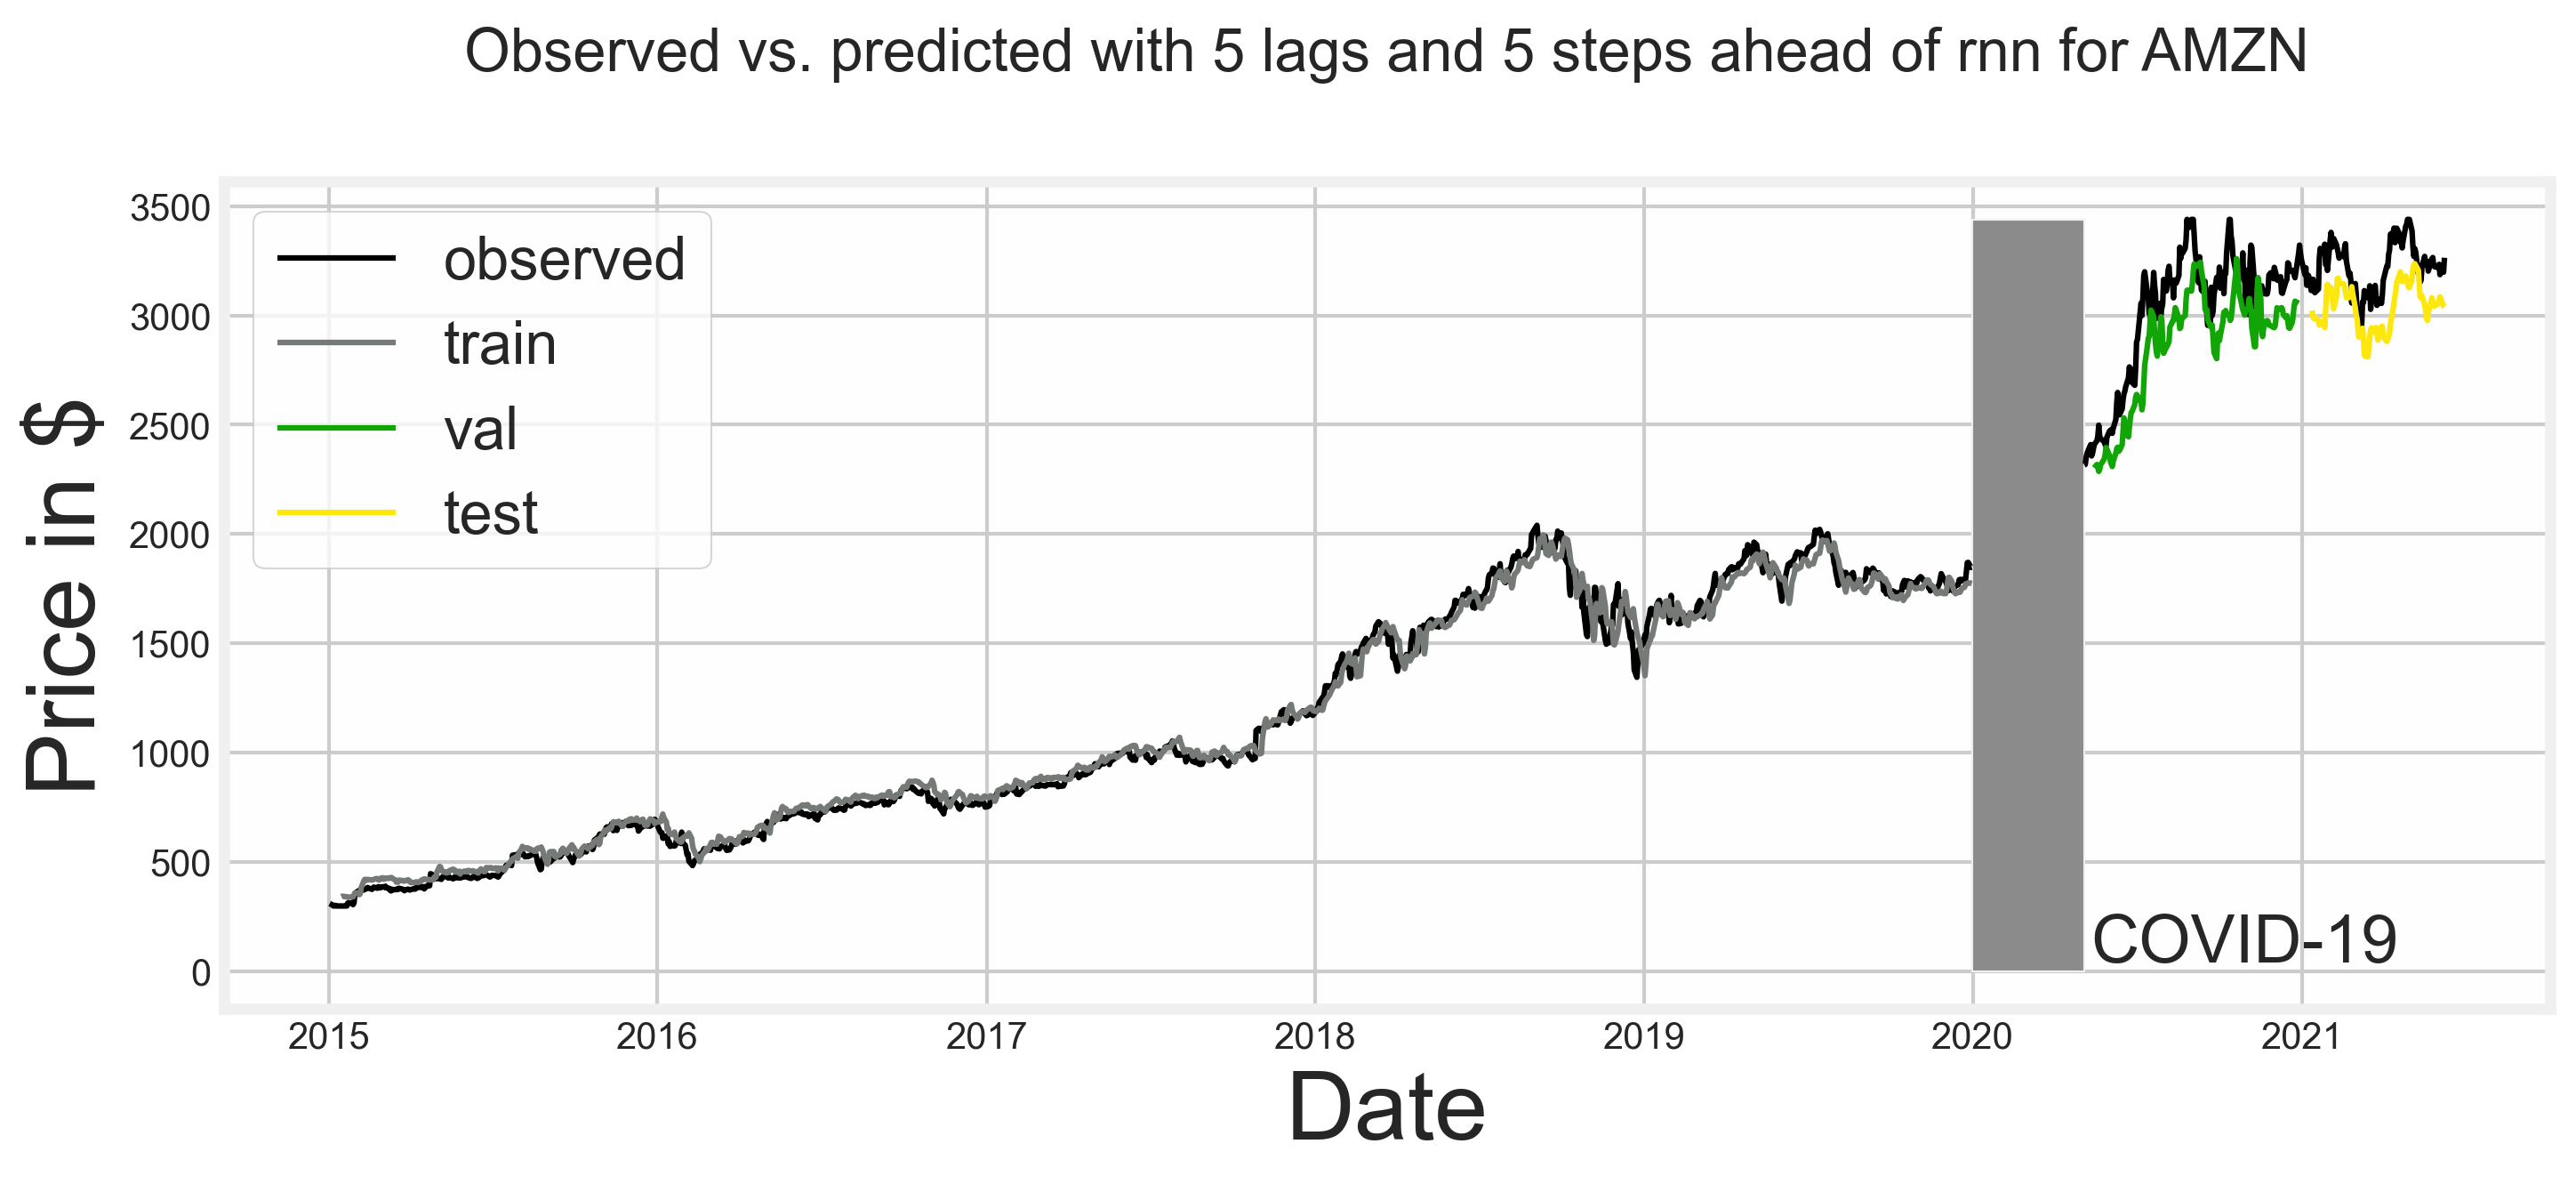

In [59]:
# rescale observed and predicted to compare
plotting.scaled_observed_vs_predicted_plot(data1, data2, key, ticker, data_train, data_val,
                                           data_test, mu, sigma, params, n_steps, n_steps_ahead, uni)

# Tensorboard

In [60]:
if uni: 
    str_path = '../logs/fit/'+ ticker +'_' + lags + '_uni_'+ key
else: 
    str_path = '../logs/fit/'+ ticker +'_' + lags + '_multi_'+ key
path = Path(str_path)

In [61]:
path

PosixPath('../logs/fit/AMZN_5_multi_rnn')

In [62]:
%load_ext tensorboard

# uncomment the function below to gain more insight of the models behavior
#%tensorboard --logdir ../logs/fit/AMZN_5_multi_rnn